## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi, drawCMS
import CMS_lumi, tdrstyle

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

## Load variables

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = ['v4','v5']
plot_folder = "v4_vs_v5"
vers = ['v5','v6']
plot_folder = "v5_vs_v6"
vers = ['v4','v5','v6']
plot_folder = "v4_vs_v5_vs_v6"
vers = ['v4','v5','v6','v7','v8','v9']
plot_folder = "v4-v9"
vers = ['v6']
plot_folder = "v6"
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA 0.4
#v6: no event level cuts, clusters made with CA and R parameter 0.6
#v7: cluster CA R=0.5
#v8: cluster CA R=0.8
#v9: cluster CA R=1.0

data_path = {}
data_label = {}
marker_style = {}
line_style = {}
colors = {}
data_label['datav4'] = 'DBSCAN data'
data_label['datav5'] = 'CA data 0.4'
data_label['datav6'] = 'CA data 0.6'
data_label['datav7'] = 'CA data 0.5'
data_label['datav8'] = 'CA data 0.8'
data_label['datav9'] = 'CA data 1.0'
data_label['datav10'] = 'CA data 0.4, merging 0.6'

data_label['signalv4'] = 'DBSCAN signal'
data_label['signalv5'] = 'CA signal 0.4'
data_label['signalv6'] = 'CA signal 0.6'
data_label['signalv7'] = 'CA signal 0.5'
data_label['signalv8'] = 'CA signal 0.8'
data_label['signalv9'] = 'CA signal 1.0'
data_label['signalv10'] = 'CA signal 0.4, merging 0.6'

marker_style['datav4'] = 20
marker_style['datav5'] = 20
marker_style['datav6'] = 20
marker_style['datav7'] = 20
marker_style['datav8'] = 20
marker_style['datav9'] = 20
marker_style['datav10'] = 20

marker_style['signalv4'] = 20
marker_style['signalv5'] = 20
marker_style['signalv6'] = 20
marker_style['signalv7'] = 20
marker_style['signalv8'] = 20
marker_style['signalv9'] = 20
marker_style['signalv10'] = 20

line_style['datav4'] = 1
line_style['datav5'] = 1
line_style['datav6'] = 1
line_style['datav7'] = 1
line_style['datav8'] = 1
line_style['datav9'] = 1
line_style['datav10'] = 1

line_style['signalv4'] = 1
line_style['signalv5'] = 2
line_style['signalv6'] = 3
line_style['signalv7'] = 3
line_style['signalv8'] = 3
line_style['signalv9'] = 3
line_style['signalv10'] = 3

colors['datav4'] = 1
colors['datav5'] = 2
colors['datav6'] = 861
colors['datav7'] = 4
colors['datav8'] = 418
colors['datav9'] = 801
colors['datav10'] = 801

colors['signalv4'] = 1
colors['signalv5'] = 2
colors['signalv6'] = 861
colors['signalv7'] = 4
colors['signalv8'] = 418
colors['signalv9'] = 801
colors['signalv10'] = 801

for ve in vers:
    data_path[ve] = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+ve+'/'
lumi = 23.02*1000

if data_year == 2022:
    for ve in vers:
        fpath['data'+ve] = data_path[ve] + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
        fpath['signal'+ve] = data_path[ve] + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    print(k)
    print("Events: ", NEvents[k])
    
for k, T in tree.items():
    branch_names = T.keys()

datav6
Events:  15508012.0
signalv6
Events:  42882900.0


In [3]:
for br in branch_names:
    if "met" in str(br):
        print(br)
    #if "g" in str(br):
    #    print(br)

b'met'
b'metPhi'


In [4]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50


intime = True
DPHI_CUT = 1

gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
gLLP_eta = {}
gLLP_phi = {}
gHiggs_pt = {}

gLLP_eta_no_sel = {}
gLLP_phi_no_sel = {}
gHiggs_pt_no_sel = {}

npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#Trigger paths
HLT_CscCluster_Loose = {}
HLT_CscCluster_Medium = {}
HLT_CscCluster_Tight = {}
HLT_L1CSCShower_DTCluster50 = {}
HLT_L1CSCShower_DTCluster75 = {}


#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpreadWeighted = {}
cscClusterTimeSpread = {}
cscClusterTimeWeighted = {}
cscClusterTimeWeighted2 = {}
cscClusterTimeWeighted3 = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}
cscClusterR = {}
cscClusterZ = {}

cscClusterNStation = {}
cscClusterMaxChamber = {}
cscClusterAvgStation = {}
cscClusterMaxStation = {}




cscClusterDphi = {}
nCscClusters = {}

#Study trigger categories:
cscClusterTimeWeightedTr1 = {}
cscClusterTimeWeightedTr2 = {}
cscClusterTimeWeightedTr3 = {}
cscClusterTimeTr1 = {}
cscClusterTimeTr2 = {}
cscClusterTimeTr3 = {}
cscClusterEtaTr1 = {}
cscClusterEtaTr2 = {}
cscClusterEtaTr3 = {}
cscClusterNStationTr1 = {}
cscClusterNStationTr2 = {}
cscClusterNStationTr3 = {}
cscClusterSizeTr1 = {}
cscClusterSizeTr2 = {}
cscClusterSizeTr3 = {}

#GenMatching
cscCluster_match_gLLP = {}
cscCluster_match_gLLP_minDeltaR = {}
cscCluster_match_gLLP_index = {}
cscCluster_match_gLLP_eta = {}
cscCluster_match_gLLP_phi = {}
cscCluster_match_gLLP_decay_r = {}
cscCluster_match_gLLP_decay_z = {}
cscCluster_match_gLLP_csc = {}
cscCluster_match_gLLP_dt = {}
cscCluster_match_gLLP_e = {}

dtCluster_match_gLLP = {}
dtCluster_match_gLLP_dt = {}
dtCluster_match_gLLP_minDeltaR = {}

#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
nDtClusters = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}


## Settings

I want to decide the category after having filled the vectors

In [5]:
do_jet_veto = False
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = False
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = False
do_csc_in_time_cut = False
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True



In [6]:
for k, T in tree.items():
    
    tree_keys.append(k)
    #if not k == 'data' and not k[-4:] == '1000':continue
    
########### SELECTION: CLUSTERS ############

    #CSC
    
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal')))
    
    sel_csccluster = T.array('cscRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_csccluster = np.logical_and(sel_csccluster, jet_veto_csc)
    if do_inverted_jet_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(jet_veto_csc))      

    if do_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, muon_veto_csc)
    if do_inverted_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(muon_veto_csc))    

    #ME11 and ME12 veto
    ME11_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')==0
    )  

    ME12_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')==0
    )
    
    if do_ME_veto:
        sel_csccluster = np.logical_and(sel_csccluster,
                                    np.logical_and(ME11_veto,ME12_veto)
                                   )           

        #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    #Time spread cut
    if do_csc_time_spread_cut:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20)
    
    #Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))
        
        
        
    #DT

    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt')) < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))
    
    sel_dtcluster = T.array('dtRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt)

    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt)    
    
    
    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1

        
    MB1_veto = T.array('dtRechitClusterNHitStation1') == 0
    
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto)                                                                 

    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    
    '''
    sel_dtcluster = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    
    cut = 5
    station = (T.array('dtRechitClusterNSegStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) 
    '''
   
    
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    #HLT_CaloMET60_DTCluster50 = hlt[:,562]
    #HLT_CaloMET60_DTClusterNoMB1S50 = hlt[:,563]
    #HLT_L1MET_DTCluster50 = hlt[:,564]
    #HLT_L1MET_DTClusterNoMB1S50 = hlt[:,565]
    HLT_CscCluster_Loose[k] = hlt[:,566]
    HLT_CscCluster_Medium[k] = hlt[:,567]
    HLT_CscCluster_Tight[k] = hlt[:,568]
    HLT_L1CSCShower_DTCluster50[k] = hlt[:,569]
    HLT_L1CSCShower_DTCluster75[k] = hlt[:,570]

    #Or of the triggers: to reduce the size
    hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose[k],np.logical_or(HLT_CscCluster_Medium[k],HLT_CscCluster_Tight[k]))
    hlt_sel_ev[k] = np.logical_or(hlt_sel_ev[k],HLT_L1CSCShower_DTCluster50[k])
    hlt_sel_ev[k] = np.logical_or(hlt_sel_ev[k],HLT_L1CSCShower_DTCluster75[k])

    #sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    #sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    #sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') > 200)
    sel_ev[k] = T.array('nLeptons') == 0
    
    #OR of all the HLT paths:
    sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    
    #At least one csc cluster, always required
    sel_ev[k] = np.logical_and(sel_ev[k],sel_csccluster.sum()>=1)
    
    #Data runs with the triggers switched on
    if 'data' in k:
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)
    

    #Categories later!
    '''
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
        #Adding this to avoid overlaps as a starting point
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 0)
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 2)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == -1:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k]) 
    '''
    
########### BRANCHES ############

    #DT

    dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]][:,:]
    
    dtCluster_match_gLLP_minDeltaR[k] = T.array('dtRechitCluster' + cluster_index + '_match_gLLP_minDeltaR')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_gLLP_dt[k] = T.array('dtRechitCluster' + cluster_index + '_match_gLLP_dt')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_gLLP[k] = T.array('dtRechitCluster' + cluster_index + '_match_gLLP')[sel_dtcluster][sel_ev[k]][:,:]
    
    #CSC
    
    cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[sel_csccluster][sel_ev[k]][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[sel_csccluster][sel_ev[k]][:,:]**2 )
    cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_csccluster][sel_ev[k]][:,:]    
    cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[sel_csccluster][sel_ev[k]][:,:]
    ##cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][sel_ev[k]][:,:]
    ##cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMaxChamber[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxChamber')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMaxStation[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxStation')[sel_csccluster][sel_ev[k]][:,:]

    
    cscCluster_match_gLLP[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP')[sel_csccluster][sel_ev[k]][:,:]
    cscCluster_match_gLLP_minDeltaR[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_minDeltaR')[sel_csccluster][sel_ev[k]][:,:]
    cscCluster_match_gLLP_index[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_index')[sel_csccluster][sel_ev[k]][:,:]
    cscCluster_match_gLLP_eta[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_eta')[sel_csccluster][sel_ev[k]][:,:]
    cscCluster_match_gLLP_phi[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_phi')[sel_csccluster][sel_ev[k]][:,:]
    cscCluster_match_gLLP_decay_r[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r')[sel_csccluster][sel_ev[k]][:,:]
    cscCluster_match_gLLP_decay_z[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z')[sel_csccluster][sel_ev[k]][:,:]
    cscCluster_match_gLLP_csc[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc')[sel_csccluster][sel_ev[k]][:,:]
    cscCluster_match_gLLP_dt[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_dt')[sel_csccluster][sel_ev[k]][:,:]
    cscCluster_match_gLLP_e[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_e')[sel_csccluster][sel_ev[k]][:,:]
        
      
     
    #Global
    
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
               
    sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
    sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        
    #This gives some errors...
    #nMe11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[sel_csccluster][sel_ev[k]][:,0]+T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[sel_csccluster][sel_ev[k]][:,0]

    #To be fixed, some issues with deltaPhi function
    #deltaRCluster[k] = deltaR(dtRechitClusterEta[k], dtRechitClusterPhi[k],cscRechitClusterEta[k], cscRechitClusterPhi[k])
    #deltaEta[k] = dtRechitClusterEta[k]-cscRechitClusterEta[k]
        


    nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k].astype(float)),where=(nDtClusters[k].astype(float) != 0))

    #Reduce size
    HLT_CscCluster_Loose[k] = HLT_CscCluster_Loose[k][ sel_ev[k] ]
    HLT_CscCluster_Medium[k] = HLT_CscCluster_Medium[k][ sel_ev[k] ]
    HLT_CscCluster_Tight[k] = HLT_CscCluster_Tight[k][ sel_ev[k] ]
    HLT_L1CSCShower_DTCluster50[k] = HLT_L1CSCShower_DTCluster50[k][ sel_ev[k] ]
    HLT_L1CSCShower_DTCluster75[k] = HLT_L1CSCShower_DTCluster75[k][ sel_ev[k] ]
    
    hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
    met[k] = T.array('met')[ sel_ev[k] ]
    gLLP_eta[k] = T.array('gLLP_eta')[ sel_ev[k] ]
    gLLP_phi[k] = T.array('gLLP_phi')[ sel_ev[k] ]
    gHiggs_pt[k] = T.array('gHiggsPt')[ sel_ev[k] ]
    
    gLLP_eta_no_sel[k] = T.array('gLLP_eta')
    gLLP_phi_no_sel[k] = T.array('gLLP_phi')
    gHiggs_pt_no_sel[k] = T.array('gHiggsPt')
    
    sel_ev[k] = sel_ev[k][ sel_ev[k] ]
    print(sel_ev[k].shape)
    print(hlt_sel_ev[k].shape)
    print(met[k].shape)



(12135343,)
(12135343,)
(12135343,)
(86995,)
(86995,)
(86995,)


In [7]:
tree_keys = list(dict.fromkeys(tree_keys))

print("Very loose selections")
for k in tree_keys:
    #if "v4" in k: print("DBSCAN")
    #if "v5" in k: print("CA 0.4")
    #if "v6" in k: print("CA 0.6")
    print(data_label[k])
    print("==0 clusters ", (nCscClusters[k]==0).sum() )
    print("==1 cluster ", (nCscClusters[k]==1).sum() )
    print(">=1 cluster ", (nCscClusters[k]>=1).sum() )
    print("==2 clusters ", (nCscClusters[k]==2).sum() )
    print(">=2 clusters ",  (nCscClusters[k]>=2).sum() )


Very loose selections
CA data 0.6
==0 clusters  0
==1 cluster  12003284
>=1 cluster  12135343
==2 clusters  129241
>=2 clusters  132059
CA signal 0.6
==0 clusters  0
==1 cluster  83631
>=1 cluster  86995
==2 clusters  3351
>=2 clusters  3364


# Category and trigger preselections

In [8]:
category = 0#-1#0
category = 1
#-1: at least 1 csc
#0: exactly 1 csc
#1: exactly 2csc,
#2: 1csc+1dt,

plot_string = ""
#plot_string+= "_exactly_1_csc_cluster_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto_csc_in_time_cut_time_spread_cut"
#plot_string+= "_at_least_1_csc_cluster_ME_veto_csc_in_time_cut_time_spread_cut"
plot_string+= "_exactly_2_csc_clusters_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_MB_veto"


category_m1_cut = {}
category_0_cut = {}
category_1_cut = {}
category_2_cut = {}


L1_plateau = {}
HLT_plateau = {}
TRG_plateau = {}
first_fired_HLT = {}
event_cut = {}

sel_trgCluster_tr1 ={}
sel_trgCluster_tr2 ={}
sel_trgCluster_tr3 ={}

first_fired_HLT = {} 
second_fired_HLT = {} 

first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}

first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}


sel_HLT_OR = {}

print(tree_keys)

for k in tree_keys:    
    print(k)

    if category==2:
        #do DT stuff
        event_cut[k] = np.logical_and(HLT_L1CSCShower_DTCluster50[k]==True,sel_ev[k])
    else:
        #do CSC stuff
        event_cut[k] = np.logical_and(HLT_CscCluster_Loose[k]==True,sel_ev[k])
    
    #Use the right variable to classify stuff here
    if category == 0:
        event_cut[k]  = np.logical_and(event_cut[k], nCscClusters[k]== 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    elif category == 1:
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] == 2)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
        #second_fired_HLT[k] = sel_HLT_OR[k][:,1]>0
    elif category == 2:      
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] == 1)
        event_cut[k]  = np.logical_and(event_cut[k],nDtClusters[k] == 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    elif category == -1:      
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] >= 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    
    
    first_in_ME11[k] = (cscClusterR[k][:,0]>100)&(cscClusterR[k][:,0]<275) &(abs(cscClusterZ[k][:,0])>580)&(abs(cscClusterZ[k][:,0])<632) 
    first_in_ME12[k] = (cscClusterR[k][:,0]>275)&(cscClusterR[k][:,0]<465) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)
    first_in_ME13[k] = (cscClusterR[k][:,0]>505)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)

    first_in_ME21[k] = (cscClusterR[k][:,0]>139)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>789)&(abs(cscClusterZ[k][:,0])<850)
    first_in_ME22[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>791)&(abs(cscClusterZ[k][:,0])<850)

    first_in_ME31[k] = (cscClusterR[k][:,0]>160)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>915)&(abs(cscClusterZ[k][:,0])<970)
    first_in_ME32[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>911)&(abs(cscClusterZ[k][:,0])<970)

    first_in_ME41[k] = (cscClusterR[k][:,0]>178)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    first_in_ME42[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    
    first_in_plateau_ME11[k] = first_in_ME11[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME21[k] = first_in_ME21[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME31[k] = first_in_ME31[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME41[k] = first_in_ME41[k] & (cscClusterSize[k][:,0]>=500)

    first_in_plateau_ME12[k] = first_in_ME12[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME13[k] = first_in_ME13[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME22[k] = (first_in_ME22[k]) & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME32[k] = first_in_ME32[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME42[k] = first_in_ME42[k] & (cscClusterSize[k][:,0]>=200)    
    
    first_in_plateau[k] = first_in_plateau_ME11[k] | first_in_plateau_ME12[k] | first_in_plateau_ME13[k] | first_in_plateau_ME21[k] | first_in_plateau_ME22[k] | first_in_plateau_ME31[k] | first_in_plateau_ME32[k] | first_in_plateau_ME41[k] | first_in_plateau_ME42[k]


['datav6', 'signalv6']
datav6
signalv6


Check when we get a dramatic difference in the number of events!!!

In [9]:
print("Category selections")
for k in tree_keys:
    #if "v4" in k: print("DBSCAN")
    #if "v5" in k: print("CA 0.4")
    #if "v6" in k: print("CA 0.6")
    print(data_label[k])
    print("==0 clusters ", (nCscClusters[k][event_cut[k]]==0).sum() )
    print("==1 cluster ", (nCscClusters[k][event_cut[k]]==1).sum() )
    #print(">=1 cluster ", (nCscClusters[k][event_cut[k]]>=1).sum() )
    print("==2 clusters ", (nCscClusters[k][event_cut[k]]==2).sum() )
    #print(">=2 clusters ",  (nCscClusters[k][event_cut[k]]>=2).sum() )

Category selections
CA data 0.6
==0 clusters  0
==1 cluster  0
==2 clusters  119478
CA signal 0.6
==0 clusters  0
==1 cluster  0
==2 clusters  3304


### Delta R between first and second cluster

{'datav6': array([ True,  True,  True, ..., False,  True, False]), 'signalv6': array([False,  True, False, ...,  True, False, False])}
datav6


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

signalv6


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/DeltaR_csc_clusters_gen_match_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/DeltaR_csc_clusters_gen_match_exactly_2_csc_clusters_ME_veto.png has been created


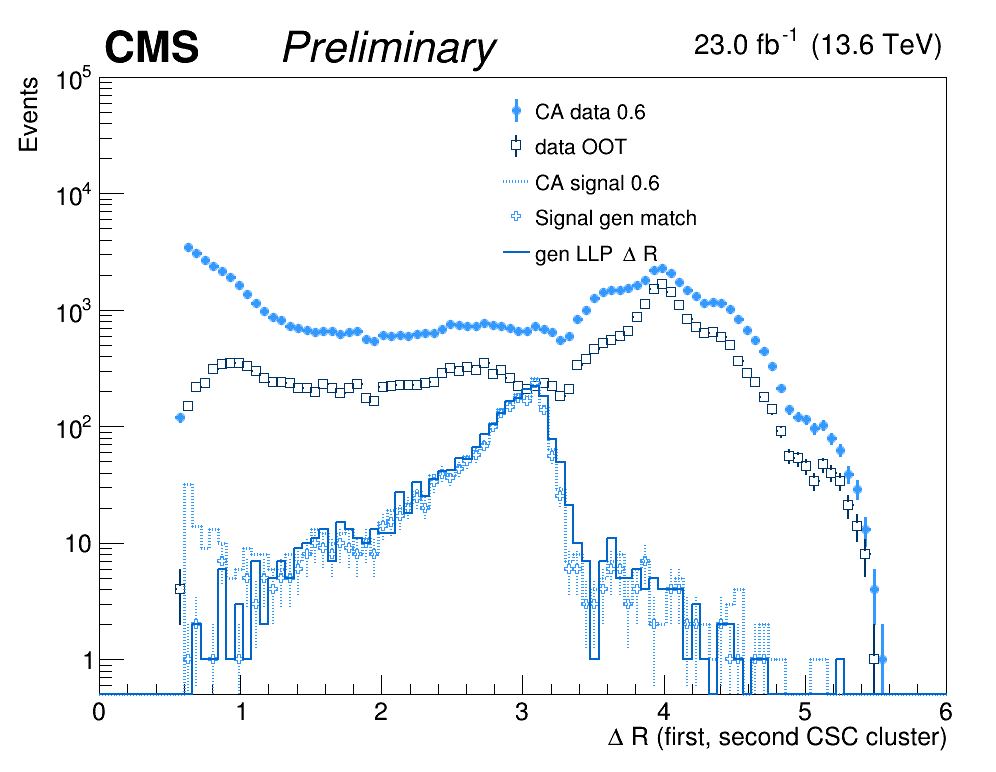

In [10]:
if category == 1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    hoot = {}
    can.cd()

    print(first_in_plateau)
    nevents_passing = {}
    for k in tree_keys:
        print(k)
        tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        tmp_cscClusterEta = cscClusterEta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        tmp_cscClusterPhi = cscClusterPhi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]

        gen_match = (cscCluster_match_gLLP_csc[k] [  cscCluster_match_gLLP_minDeltaR[k]<0.4 ].sum() == 2  )
    
        #print(gen_match.shape)
        #print(first_in_plateau[k].shape)
        #print(gen_match)
 

        tmp_eta_gm = cscClusterEta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k]  & gen_match]
        tmp_phi_gm = cscClusterPhi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k] & gen_match ]

        #print(tmp_cscClusterEta.shape)
        #print(tmp_eta_gm.shape)
    
        #tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  ]
        #tmp_cscClusterEta = cscClusterEta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) ]
        #tmp_cscClusterPhi = cscClusterPhi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  ]
        #print( deltaR(tmp_cscClusterEta[:,0].flatten(), tmp_cscClusterPhi[:,0].flatten(), tmp_cscClusterEta[:,1].flatten(), tmp_cscClusterPhi[:,1].flatten()) )
        tmp_dR = deltaR(tmp_cscClusterEta[:,0].flatten(), tmp_cscClusterPhi[:,0].flatten(), tmp_cscClusterEta[:,1].flatten(), tmp_cscClusterPhi[:,1].flatten())
        tmp_dR_gm = deltaR(tmp_eta_gm[:,0].flatten(),tmp_phi_gm[:,0].flatten(),tmp_eta_gm[:,1].flatten(),tmp_phi_gm[:,1].flatten())
        #print( (p1 - p2 + np.pi) % (2 * np.pi) - np.pi )

        tmp_eta_gen = gLLP_eta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dR = deltaR(tmp_eta_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,0].flatten(),tmp_eta_gen[dim_cut][:,1].flatten(),tmp_phi_gen[dim_cut][:,1].flatten())
    
        h1[k] = create_TH1D(tmp_dR,title="",axis_title = ['#Delta R (first, second CSC cluster)','Events'], binning=[100,0,6])
        hsm[k] = create_TH1D(tmp_dR_gm,title="",axis_title = ['#Delta R (first, second CSC cluster)','Events'], binning=[100,0,6])
        hg[k] = create_TH1D(gLLP_dR,title="",axis_title = ['#Delta R (first, second CSC cluster)','Events'], binning=[100,0,6])

        tmp_oot = (np.abs(cscClusterTime[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ][:,1]) > 50)
        tmp_dR_oot = np.abs(deltaR(tmp_cscClusterEta[tmp_oot][:,0].flatten(), tmp_cscClusterPhi[tmp_oot][:,0].flatten(), tmp_cscClusterEta[tmp_oot][:,1].flatten(), tmp_cscClusterPhi[tmp_oot][:,1].flatten()))
        hoot[k] = create_TH1D(tmp_dR_oot,title="",axis_title = ['|#Delta R (first, second CSC cluster)|','Events'], binning=[100,0,6])
    
        leg.AddEntry(h1[k],data_label[k],'PE' if 'data' in k else 'L')
        h1[k].SetLineColor(colors[k])
        h1[k].SetLineWidth(3)
        h1[k].SetLineStyle(line_style[k])
        h1[k].SetMarkerColor(colors[k])
        h1[k].SetMarkerStyle(marker_style[k])
        h1[k].SetMarkerSize(1.2)
        #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
        
        
        if 'data' in k:
            hoot[k].SetLineColor(colors[k]+2)
            hoot[k].SetLineWidth(2)
            hoot[k].SetLineStyle(1)
            hoot[k].SetMarkerColor(colors[k]+2)
            hoot[k].SetMarkerStyle(25)
            hoot[k].SetMarkerSize(1.2)
            hoot[k].Draw('PE same')
            leg.AddEntry(hoot[k],'data OOT','PE')
        h1[k].SetMaximum(1.e05)
    
        hsm[k].SetLineColor(colors[k])
        hsm[k].SetLineWidth(2)
        hsm[k].SetLineStyle(line_style[k])
        hsm[k].SetMarkerColor(colors[k])
        hsm[k].SetMarkerStyle(28)
        hsm[k].SetMarkerSize(1.2)

        hg[k].SetLineColor(colors[k]+1)
        hg[k].SetLineWidth(2)
        hg[k].SetLineStyle(1)
        hg[k].SetMarkerColor(colors[k]+1)
        hg[k].SetMarkerStyle(28)
        hg[k].SetMarkerSize(1.2)    
        if 'signal' in k:
            leg.AddEntry(hsm[k],'Signal gen match','P')
            leg.AddEntry(hg[k],'gen LLP #Delta R',"L")
            hsm[k].Draw('P same')
            hg[k].Draw('HISTO same')

    
        nevents_passing[k] = event_cut[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k]  ].sum()
    
    leg.Draw()
    can.SetRightMargin(0.05)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/DeltaR_csc_clusters_gen_match"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/DeltaR_csc_clusters_gen_match"+plot_string+".png")
    #can.Close()

In [11]:
if category == 2:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    print(first_in_plateau)
    nevents_passing = {}
    for k in tree_keys:
        print(k)
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)

        #print(cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0])
        #print((cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4))
        #print((cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4).sum())
        #print((cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4).sum()==1)
        #exit()

        #This must be fixed to dt-csc...
        gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
    
        #print(gen_match.shape)
        #print(first_in_plateau[k].shape)
        #print(gen_match)
        #print(tmp_dtClusterSize.shape)
        #print(tmp_dtClusterSize)
 

        tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        tmp_dR = deltaR(tmp_cscClusterEta.flatten(), tmp_cscClusterPhi.flatten(), tmp_dtClusterEta.flatten(), tmp_dtClusterPhi.flatten())
        tmp_dR_gm = deltaR(tmp_csc_eta_gm.flatten(),tmp_csc_phi_gm.flatten(),tmp_dt_eta_gm.flatten(),tmp_dt_phi_gm.flatten())

        tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dR = deltaR(tmp_eta_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,0].flatten(),tmp_eta_gen[dim_cut][:,1].flatten(),tmp_phi_gen[dim_cut][:,1].flatten())
    
        h1[k] = create_TH1D(tmp_dR,title="",axis_title = ['#Delta R (CSC, DT cluster)','Events'], binning=[100,0,6])
        hsm[k] = create_TH1D(tmp_dR_gm,title="",axis_title = ['#Delta R (CSC, DT cluster)','Events'], binning=[100,0,6])
        hg[k] = create_TH1D(gLLP_dR,title="",axis_title = ['#Delta R (CSC, DT cluster)','Events'], binning=[100,0,6])
    
        leg.AddEntry(h1[k],data_label[k],'PE' if 'data' in k else 'L')
        h1[k].SetLineColor(colors[k])
        h1[k].SetLineWidth(3)
        h1[k].SetLineStyle(line_style[k])
        h1[k].SetMarkerColor(colors[k])
        h1[k].SetMarkerStyle(marker_style[k])
        h1[k].SetMarkerSize(1.2)
        #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
        h1[k].SetMaximum(1.e05)
    
        hsm[k].SetLineColor(colors[k])
        hsm[k].SetLineWidth(2)
        hsm[k].SetLineStyle(line_style[k])
        hsm[k].SetMarkerColor(colors[k])
        hsm[k].SetMarkerStyle(28)
        hsm[k].SetMarkerSize(1.2)

        hg[k].SetLineColor(colors[k]+1)
        hg[k].SetLineWidth(2)
        hg[k].SetLineStyle(1)
        hg[k].SetMarkerColor(colors[k]+1)
        hg[k].SetMarkerStyle(28)
        hg[k].SetMarkerSize(1.2)    
        if 'signal' in k:
            leg.AddEntry(hsm[k],'Signal gen match','P')
            leg.AddEntry(hg[k],'gen LLP #Delta R',"L")
            hsm[k].Draw('P same')
            hg[k].Draw('HISTO same')

        
        nevents_passing[k] = event_cut[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k]  ].sum()
    
    leg.Draw()
    can.SetRightMargin(0.05)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/DeltaR_csc_dt_clusters_gen_match"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/DeltaR_csc_dt_clusters_gen_match"+plot_string+".png")
    #can.Close()

## Delta R LLP vs gen higgs pT

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

(3304,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/GenDeltaR_vs_Higgs_pT_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/GenDeltaR_vs_Higgs_pT_exactly_2_csc_clusters_ME_veto.png has been created


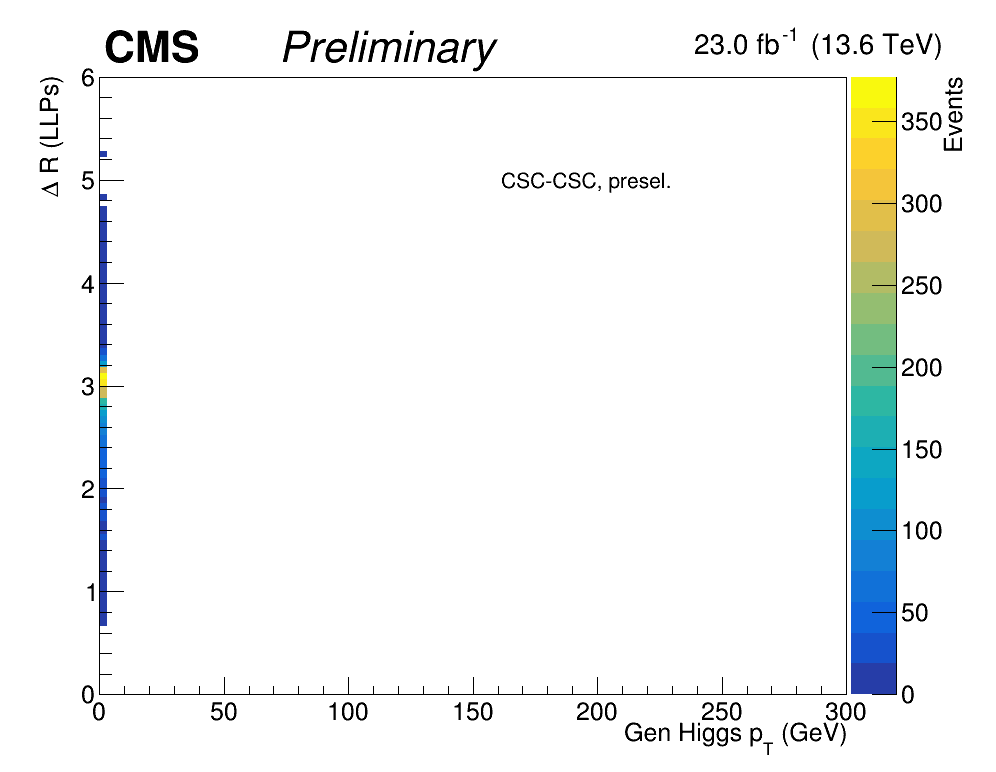

In [12]:
if category == 2 or category==1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    for k in tree_keys:
        #tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        #tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)

        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)

        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        #tmp_dR = deltaR(tmp_cscClusterEta.flatten(), tmp_cscClusterPhi.flatten(), tmp_dtClusterEta.flatten(), tmp_dtClusterPhi.flatten())
        #tmp_dR_gm = deltaR(tmp_csc_eta_gm.flatten(),tmp_csc_phi_gm.flatten(),tmp_dt_eta_gm.flatten(),tmp_dt_phi_gm.flatten())

        tmp_eta_gen = gLLP_eta[k][ event_cut[k]  ]
        tmp_phi_gen = gLLP_phi[k][ event_cut[k]  ]
        tmp_pt_h = gHiggs_pt[k][ event_cut[k]  ]
    
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dR = deltaR(tmp_eta_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,0].flatten(),tmp_eta_gen[dim_cut][:,1].flatten(),tmp_phi_gen[dim_cut][:,1].flatten())
        pt_h = tmp_pt_h[dim_cut]
        #print(np.vstack((pt_h, gLLP_dR)).T)
        h2[k] = create_TH2D(np.vstack((pt_h, gLLP_dR)).T,title="",axis_title = ['Gen Higgs p_{T} (GeV)','#Delta R (LLPs)','Events'], binning=[100,0,300,100,0,6])
        leg.SetHeader('CSC-CSC, presel.' if category==1 else 'DT-CSC, presel.')
        #h2[k].SetMaximum(100)
        if 'signal' in k:
            h2[k].Draw("colz")
            print(event_cut[k][ event_cut[k] == True].shape)

        
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    #can.SetLogz()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaR_vs_Higgs_pT"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaR_vs_Higgs_pT"+plot_string+".png")
    #can.Close()

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

(2078,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/GenDeltaR_vs_Higgs_pT_in_plateau_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/GenDeltaR_vs_Higgs_pT_in_plateau_exactly_2_csc_clusters_ME_veto.png has been created


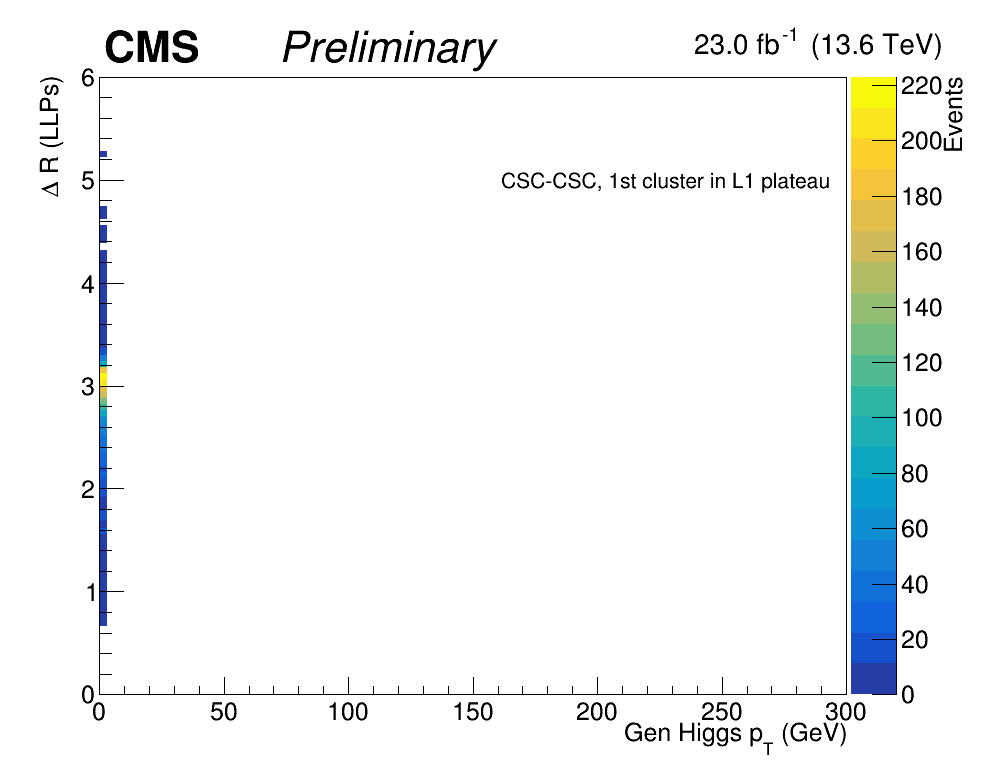

In [13]:
if category == 2 or category==1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    for k in tree_keys:
        #tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        #tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        #tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)

        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)

        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        #tmp_dR = deltaR(tmp_cscClusterEta.flatten(), tmp_cscClusterPhi.flatten(), tmp_dtClusterEta.flatten(), tmp_dtClusterPhi.flatten())
        #tmp_dR_gm = deltaR(tmp_csc_eta_gm.flatten(),tmp_csc_phi_gm.flatten(),tmp_dt_eta_gm.flatten(),tmp_dt_phi_gm.flatten())

        tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_pt_h = gHiggs_pt[k][ event_cut[k] & first_in_plateau[k] ]
    
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dR = deltaR(tmp_eta_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,0].flatten(),tmp_eta_gen[dim_cut][:,1].flatten(),tmp_phi_gen[dim_cut][:,1].flatten())
        pt_h = tmp_pt_h[dim_cut]
        #print(np.vstack((pt_h, gLLP_dR)).T)
        h2[k] = create_TH2D(np.vstack((pt_h, gLLP_dR)).T,title="",axis_title = ['Gen Higgs p_{T} (GeV)','#Delta R (LLPs)','Events'], binning=[100,0,300,100,0,6])
        leg.SetHeader('CSC-CSC, 1st cluster in L1 plateau' if category==1 else 'DT-CSC, CSC cluster in L1 plateau')
        #h2[k].SetMaximum(100)
        if 'signal' in k:
            h2[k].Draw("colz")
            print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)

        
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    #can.SetLogz()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaR_vs_Higgs_pT_in_plateau"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaR_vs_Higgs_pT_in_plateau"+plot_string+".png")
    #can.Close()

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

(3304,)


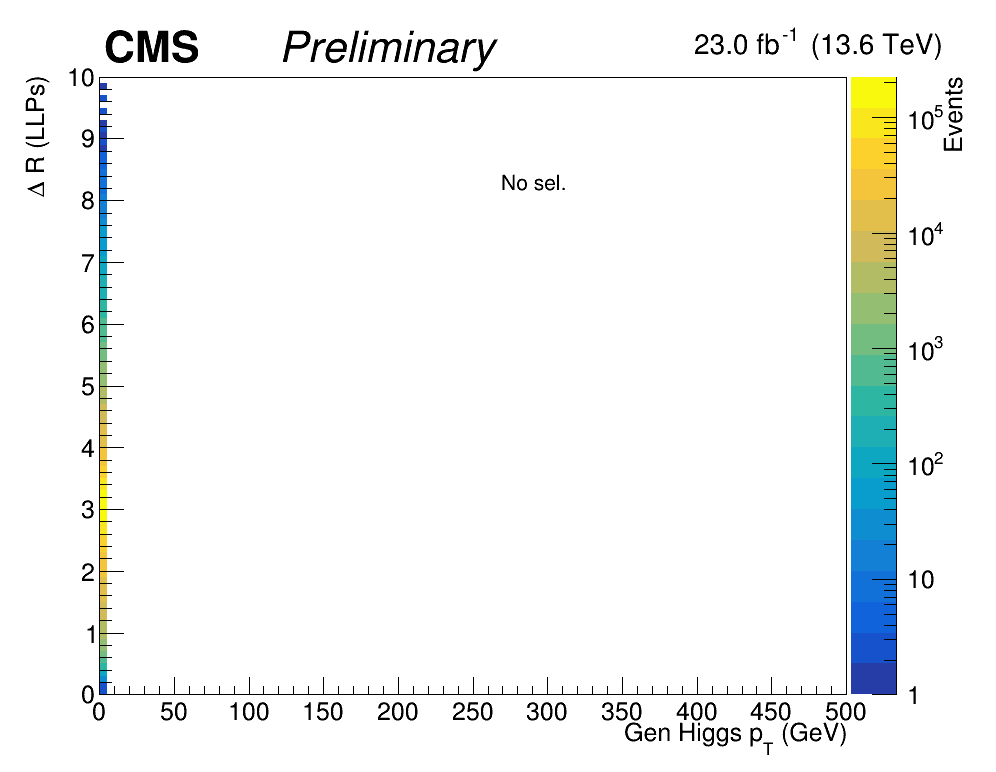

In [14]:
if category == 2 or category==1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    for k in tree_keys:
        tmp_eta_gen = gLLP_eta_no_sel[k]#[ event_cut[k]  ]
        tmp_phi_gen = gLLP_phi_no_sel[k]#[ event_cut[k]  ]
        tmp_pt_h = gHiggs_pt_no_sel[k]
    
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dR = deltaR(tmp_eta_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,0].flatten(),tmp_eta_gen[dim_cut][:,1].flatten(),tmp_phi_gen[dim_cut][:,1].flatten())
        pt_h = tmp_pt_h[dim_cut]
        h2[k] = create_TH2D(np.vstack((pt_h, gLLP_dR)).T,title="",axis_title = ['Gen Higgs p_{T} (GeV)','#Delta R (LLPs)','Events'], binning=[100,0,500,100,0,10])
        leg.SetHeader('No sel.')
        #h2[k].SetMaximum(100)
        if 'signal' in k:
            h2[k].Draw("colz")
            print(event_cut[k][ event_cut[k] == True].shape)

        
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    can.SetLogz()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaR_vs_Higgs_pT_no_sel.pdf")
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaR_vs_Higgs_pT_no_sel.png")
    #can.Close()

## Gen Delta R vs MET

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

(2078,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/GenDeltaR_vs_MET_in_plateau_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/GenDeltaR_vs_MET_in_plateau_exactly_2_csc_clusters_ME_veto.png has been created


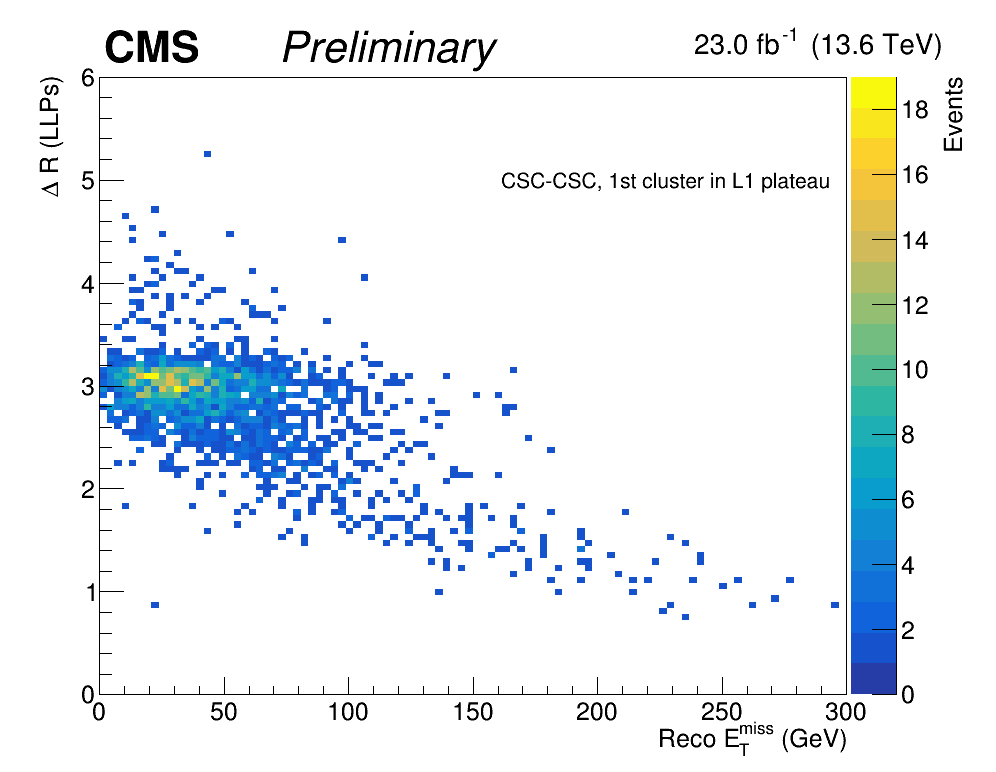

In [15]:
if category == 2 or category==1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    for k in tree_keys:
        tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
    
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dR = deltaR(tmp_eta_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,0].flatten(),tmp_eta_gen[dim_cut][:,1].flatten(),tmp_phi_gen[dim_cut][:,1].flatten())
        reco_met = tmp_met[dim_cut]
        h2[k] = create_TH2D(np.vstack((reco_met, gLLP_dR)).T,title="",axis_title = ['Reco E_{T}^{miss} (GeV)','#Delta R (LLPs)','Events'], binning=[100,0,300,100,0,6])
        leg.SetHeader('CSC-CSC, 1st cluster in L1 plateau' if category==1 else 'DT-CSC, CSC cluster in L1 plateau')
        #h2[k].SetMaximum(100)
        if 'signal' in k:
            h2[k].Draw("colz")
            print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)

        
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    #can.SetLogz()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaR_vs_MET_in_plateau"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaR_vs_MET_in_plateau"+plot_string+".png")
    #can.Close()

### Reco delta R vs MET

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

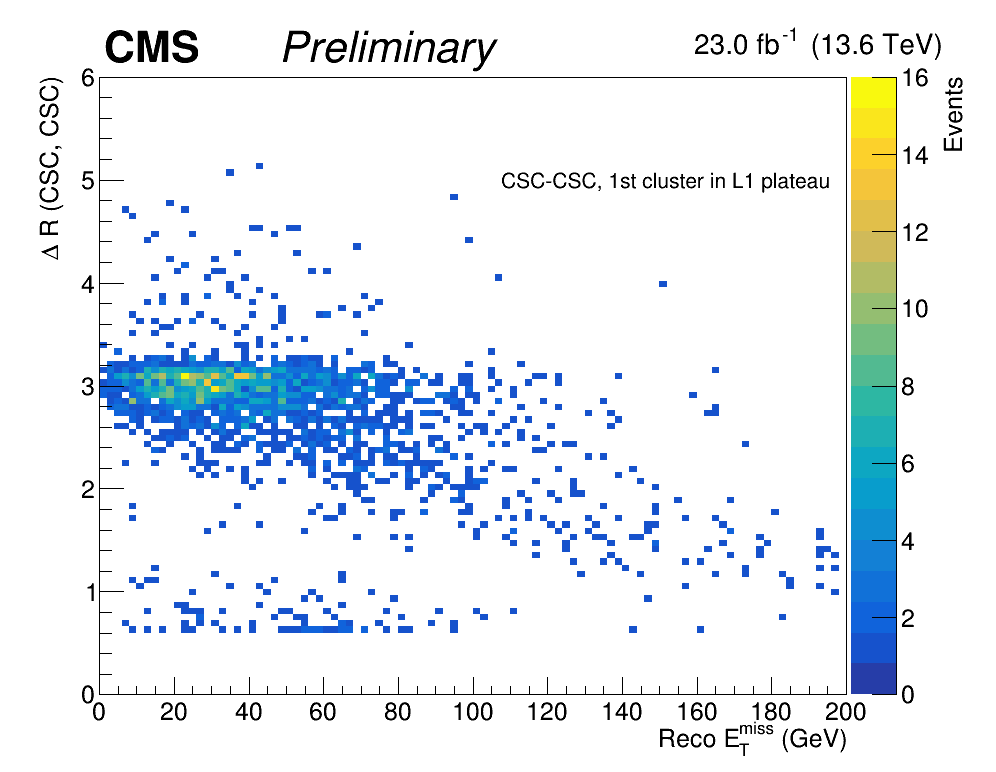

In [16]:
if category == 2 or category==1:
    for k in tree_keys:
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.65,0.65,0.88)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()        
        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            
        gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        tmp_dR = np.abs(deltaR(tmp_cscClusterEta.flatten(),tmp_cscClusterPhi.flatten(), tmp_dtClusterEta.flatten(), tmp_dtClusterPhi.flatten()))
        tmp_dR_gm = np.abs(deltaR(tmp_csc_eta_gm.flatten(),tmp_csc_phi_gm.flatten(),tmp_dt_eta_gm.flatten(),tmp_dt_phi_gm.flatten()))

        tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dR = np.abs(deltaR(tmp_eta_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,0].flatten(),tmp_eta_gen[dim_cut][:,1].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        reco_met = tmp_met[dim_cut]

        h2[k] = create_TH2D(np.vstack((tmp_met, tmp_dR)).T,title="",axis_title = ['Reco E_{T}^{miss} (GeV)','#Delta R (CSC, '+('DT' if category==2 else 'CSC')+')','Events'], binning=[100,0,200,100,0,6])
        leg.SetHeader('CSC-CSC, 1st cluster in L1 plateau' if category==1 else 'DT-CSC, CSC cluster in L1 plateau')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)

        
        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaR_vs_MET_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaR_vs_MET_in_plateau_"+k+plot_string+".png")
        #can.Close()

## Delta Phi

{'datav6': array([ True,  True,  True, ..., False,  True, False]), 'signalv6': array([False,  True, False, ...,  True, False, False])}
datav6


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

signalv6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/DeltaPhi_csc_clusters_gen_match_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/DeltaPhi_csc_clusters_gen_match_exactly_2_csc_clusters_ME_veto.png has been created


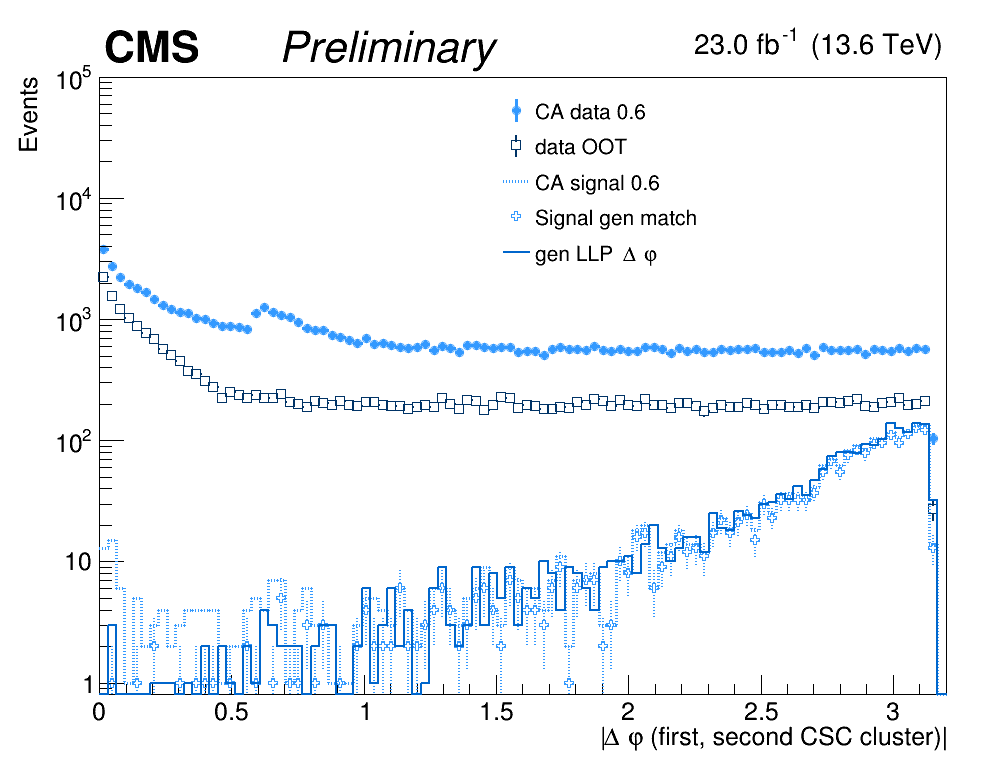

In [17]:
if category == 1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    hoot = {}
    can.cd()

    print(first_in_plateau)
    nevents_passing = {}
    for k in tree_keys:
        print(k)
        tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        tmp_cscClusterEta = cscClusterEta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        tmp_cscClusterPhi = cscClusterPhi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        tmp_cscClusterTime = cscClusterTime[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]

        gen_match = (cscCluster_match_gLLP_csc[k] [  cscCluster_match_gLLP_minDeltaR[k]<0.4 ].sum() == 2  )

        tmp_eta_gm = cscClusterEta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k]  & gen_match]
        tmp_phi_gm = cscClusterPhi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k] & gen_match ]

        tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[:,0].flatten(), tmp_cscClusterPhi[:,1].flatten()))
        tmp_dPhi_gm = np.abs(deltaPhi(tmp_phi_gm[:,0].flatten(),tmp_phi_gm[:,1].flatten()))

        tmp_eta_gen = gLLP_eta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))
        
    
        h1[k] = create_TH1D(tmp_dPhi,title="",axis_title = ['|#Delta #varphi (first, second CSC cluster)|','Events'], binning=[100,0,3.2])
        hsm[k] = create_TH1D(tmp_dPhi_gm,title="",axis_title = ['|#Delta #varphi (first, second CSC cluster)|','Events'], binning=[100,0,3.2])
        hg[k] = create_TH1D(gLLP_dPhi,title="",axis_title = ['|#Delta #varphi (first, second CSC cluster)|','Events'], binning=[100,0,3.2])

        tmp_oot = (np.abs(cscClusterTime[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ][:,1]) > 50)
        tmp_dPhi_oot = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_oot][:,0].flatten(), tmp_cscClusterPhi[tmp_oot][:,1].flatten()))
        hoot[k] = create_TH1D(tmp_dPhi_oot,title="",axis_title = ['|#Delta #varphi (first, second CSC cluster)|','Events'], binning=[100,0,3.2])


        leg.AddEntry(h1[k],data_label[k],'PE' if 'data' in k else 'L')
        h1[k].SetLineColor(colors[k])
        h1[k].SetLineWidth(3)
        h1[k].SetLineStyle(line_style[k])
        h1[k].SetMarkerColor(colors[k])
        h1[k].SetMarkerStyle(marker_style[k])
        h1[k].SetMarkerSize(1.2)
        h1[k].SetMinimum(0.8)
        #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
        h1[k].SetMaximum(1.e05)
        if 'data' in k:
            hoot[k].SetLineColor(colors[k]+2)
            hoot[k].SetLineWidth(2)
            hoot[k].SetLineStyle(1)
            hoot[k].SetMarkerColor(colors[k]+2)
            hoot[k].SetMarkerStyle(25)
            hoot[k].SetMarkerSize(1.2)
            hoot[k].Draw('PE same')
            leg.AddEntry(hoot[k],'data OOT','PE')
    
        hsm[k].SetLineColor(colors[k])
        hsm[k].SetLineWidth(2)
        hsm[k].SetLineStyle(line_style[k])
        hsm[k].SetMarkerColor(colors[k])
        hsm[k].SetMarkerStyle(28)
        hsm[k].SetMarkerSize(1.2)

        hg[k].SetLineColor(colors[k]+1)
        hg[k].SetLineWidth(2)
        hg[k].SetLineStyle(1)
        hg[k].SetMarkerColor(colors[k]+1)
        hg[k].SetMarkerStyle(28)
        hg[k].SetMarkerSize(1.2)    
        if 'signal' in k:
            leg.AddEntry(hsm[k],'Signal gen match','P')
            leg.AddEntry(hg[k],'gen LLP #Delta #varphi',"L")
            hsm[k].Draw('P same')
            hg[k].Draw('HISTO same')

    
        nevents_passing[k] = event_cut[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k]  ].sum()
    
    leg.Draw()
    can.SetRightMargin(0.05)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_csc_clusters_gen_match"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_csc_clusters_gen_match"+plot_string+".png")
    #can.Close()

In [18]:
if category == 2:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hoot = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    #print(first_in_plateau)
    nevents_passing = {}
    for k in tree_keys:
        #print(k)
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        
        #This must be fixed to dt-csc...
        gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
    

        tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]
        
        tmp_oot = (dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0] !=0)

        tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
        tmp_dPhi_oot = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_oot].flatten(), tmp_dtClusterPhi[tmp_oot].flatten()))
        tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))
    
        h1[k] = create_TH1D(tmp_dPhi,title="",axis_title = ['|#Delta #varphi (CSC, DT cluster)|','Events'], binning=[100,0,3.2])
        hsm[k] = create_TH1D(tmp_dPhi_gm,title="",axis_title = ['|#Delta #varphi (CSC, DT cluster)|','Events'], binning=[100,0,3.2])
        hg[k] = create_TH1D(gLLP_dPhi,title="",axis_title = ['|#Delta #varphi (CSC, DT cluster)|','Events'], binning=[100,0,3.2])
        hoot[k] = create_TH1D(tmp_dPhi_oot,title="",axis_title = ['|#Delta #varphi (CSC, DT cluster)|','Events'], binning=[100,0,3.2])

        leg.AddEntry(h1[k],data_label[k],'PE' if 'data' in k else 'L')
        h1[k].SetLineColor(colors[k])
        h1[k].SetLineWidth(3)
        h1[k].SetLineStyle(line_style[k])
        h1[k].SetMarkerColor(colors[k])
        h1[k].SetMarkerStyle(marker_style[k])
        h1[k].SetMarkerSize(1.2)
        #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
        if 'data' in k:
            hoot[k].SetLineColor(colors[k]+2)
            hoot[k].SetLineWidth(2)
            hoot[k].SetLineStyle(1)
            hoot[k].SetMarkerColor(colors[k]+2)
            hoot[k].SetMarkerStyle(25)
            hoot[k].SetMarkerSize(1.2)
            hoot[k].Draw('PE same')
            leg.AddEntry(hoot[k],'data OOT','PE')
        h1[k].SetMaximum(1.e05)
    
        hsm[k].SetLineColor(colors[k])
        hsm[k].SetLineWidth(2)
        hsm[k].SetLineStyle(line_style[k])
        hsm[k].SetMarkerColor(colors[k])
        hsm[k].SetMarkerStyle(28)
        hsm[k].SetMarkerSize(1.2)

        hg[k].SetLineColor(colors[k]+1)
        hg[k].SetLineWidth(2)
        hg[k].SetLineStyle(1)
        hg[k].SetMarkerColor(colors[k]+1)
        hg[k].SetMarkerStyle(28)
        hg[k].SetMarkerSize(1.2)    
        if 'signal' in k:
            leg.AddEntry(hsm[k],'Signal gen match','P')
            leg.AddEntry(hg[k],'gen LLP #Delta #varphi',"L")
            hsm[k].Draw('P same')
            hg[k].Draw('HISTO same')

        
        nevents_passing[k] = event_cut[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k]  ].sum()
    
    leg.Draw()
    can.SetRightMargin(0.05)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_csc_dt_clusters_gen_match"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_csc_dt_clusters_gen_match"+plot_string+".png")
    #can.Close()

## Delta Phi vs gen Higgs pT

(3304,)


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

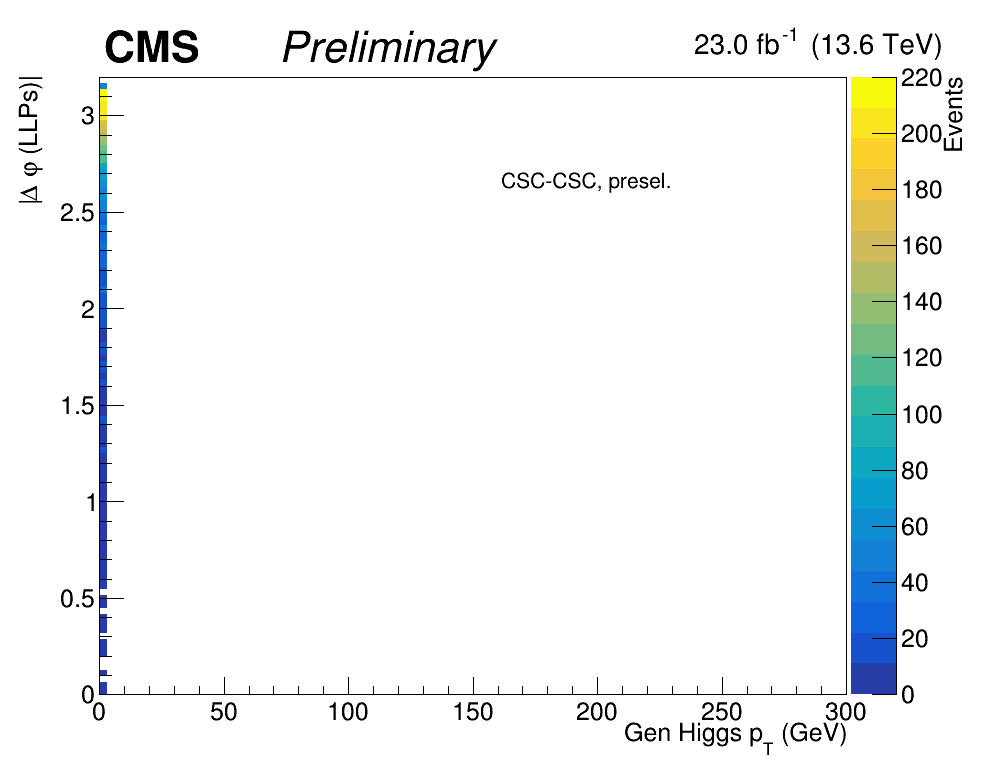

In [19]:
if category == 2 or category==1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    for k in tree_keys:
        tmp_eta_gen = gLLP_eta[k][ event_cut[k]  ]
        tmp_phi_gen = gLLP_phi[k][ event_cut[k]  ]
        tmp_pt_h = gHiggs_pt[k][ event_cut[k]  ]
    
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))
        pt_h = tmp_pt_h[dim_cut]
        h2[k] = create_TH2D(np.vstack((pt_h, gLLP_dPhi)).T,title="",axis_title = ['Gen Higgs p_{T} (GeV)','|#Delta #varphi (LLPs)|','Events'], binning=[100,0,300,100,0,3.2])
        leg.SetHeader('CSC-CSC, presel.' if category==1 else 'DT-CSC, presel.')
        if 'signal' in k:
            h2[k].Draw("colz")
            print(event_cut[k][ event_cut[k] == True].shape)

        
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    #can.SetLogz()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaPhi_vs_Higgs_pT"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaPhi_vs_Higgs_pT"+plot_string+".png")
    #can.Close()

(2078,)


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

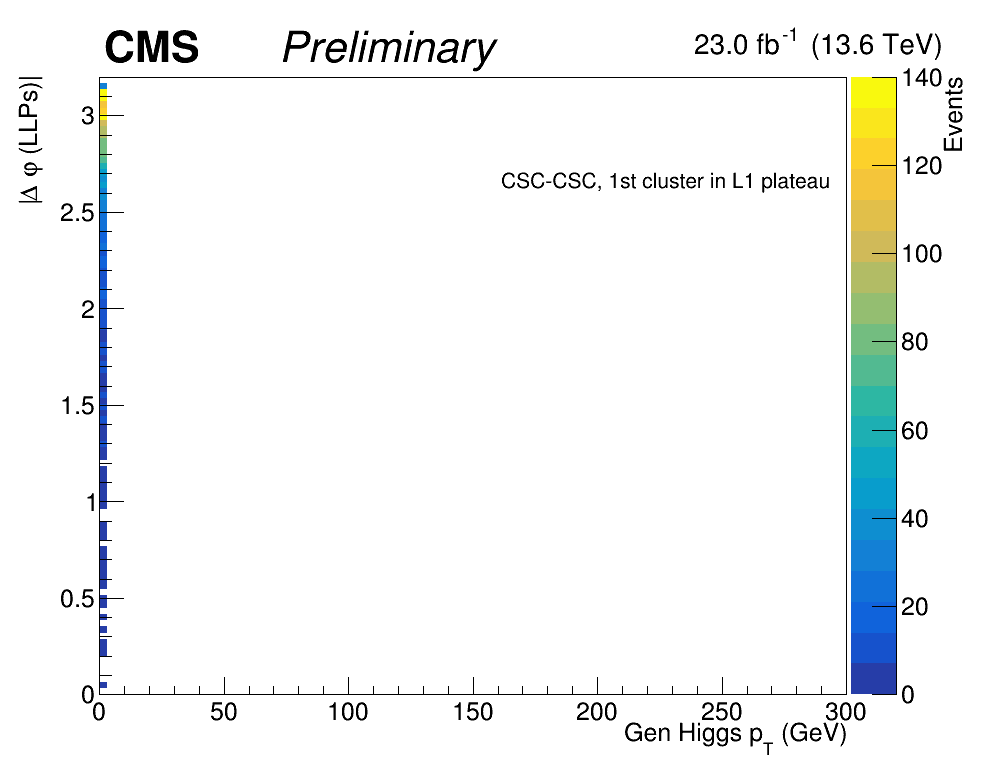

In [20]:
if category == 2 or category==1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    for k in tree_keys:
        tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_pt_h = gHiggs_pt[k][ event_cut[k] & first_in_plateau[k] ]
    
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))
        pt_h = tmp_pt_h[dim_cut]
        #print(np.vstack((pt_h, gLLP_dR)).T)
        h2[k] = create_TH2D(np.vstack((pt_h, gLLP_dPhi)).T,title="",axis_title = ['Gen Higgs p_{T} (GeV)','|#Delta #varphi (LLPs)|','Events'], binning=[100,0,300,100,0,3.2])
        leg.SetHeader('CSC-CSC, 1st cluster in L1 plateau' if category==1 else 'DT-CSC, CSC cluster in L1 plateau')
        #h2[k].SetMaximum(100)
        if 'signal' in k:
            h2[k].Draw("colz")
            print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)

        
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    #can.SetLogz()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaPhi_vs_Higgs_pT_in_plateau"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaPhi_vs_Higgs_pT_in_plateau"+plot_string+".png")
    #can.Close()

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

(3304,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/GenDeltaPhi_vs_Higgs_pT_no_sel.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/GenDeltaPhi_vs_Higgs_pT_no_sel.png has been created


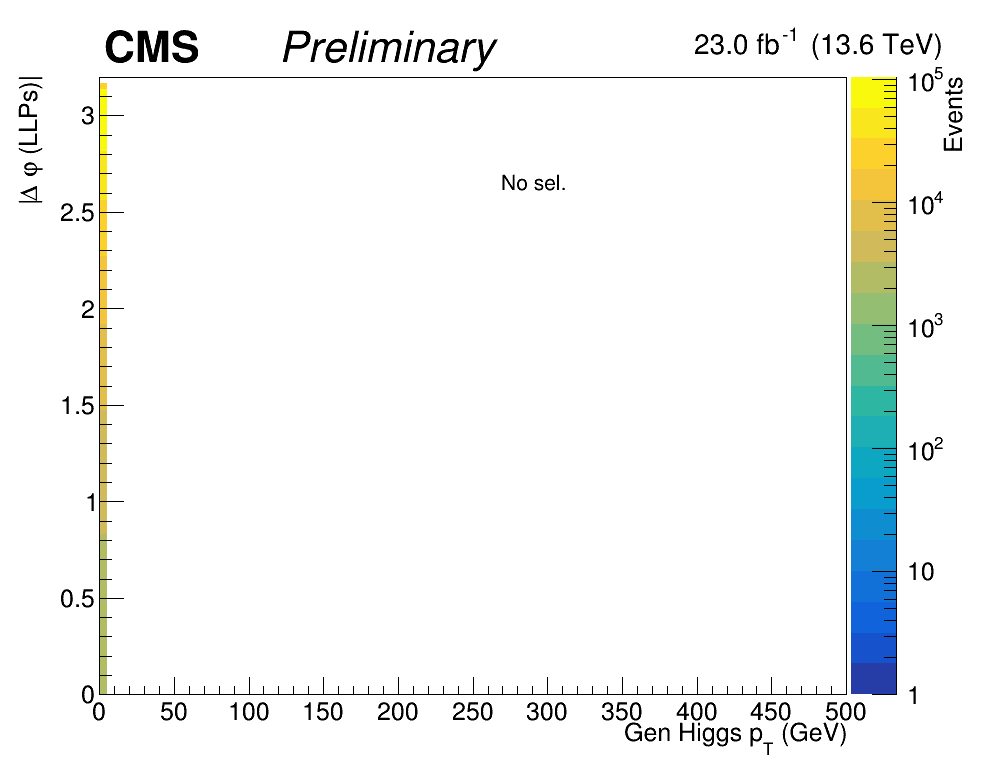

In [21]:
if category == 2 or category==1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    for k in tree_keys:
        tmp_eta_gen = gLLP_eta_no_sel[k]#[ event_cut[k]  ]
        tmp_phi_gen = gLLP_phi_no_sel[k]#[ event_cut[k]  ]
        tmp_pt_h = gHiggs_pt_no_sel[k]
    
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))
        pt_h = tmp_pt_h[dim_cut]
        h2[k] = create_TH2D(np.vstack((pt_h, gLLP_dPhi)).T,title="",axis_title = ['Gen Higgs p_{T} (GeV)','|#Delta #varphi (LLPs)|','Events'], binning=[100,0,500,100,0,3.2])
        leg.SetHeader('No sel.')
        #h2[k].SetMaximum(100)
        if 'signal' in k:
            h2[k].Draw("colz")
            print(event_cut[k][ event_cut[k] == True].shape)

        
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    can.SetLogz()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaPhi_vs_Higgs_pT_no_sel.pdf")
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaPhi_vs_Higgs_pT_no_sel.png")
    #can.Close()

### Gen delta phi vs MET

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

(2078,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/GenDeltaPhi_vs_MET_in_plateau_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/GenDeltaPhi_vs_MET_in_plateau_exactly_2_csc_clusters_ME_veto.png has been created


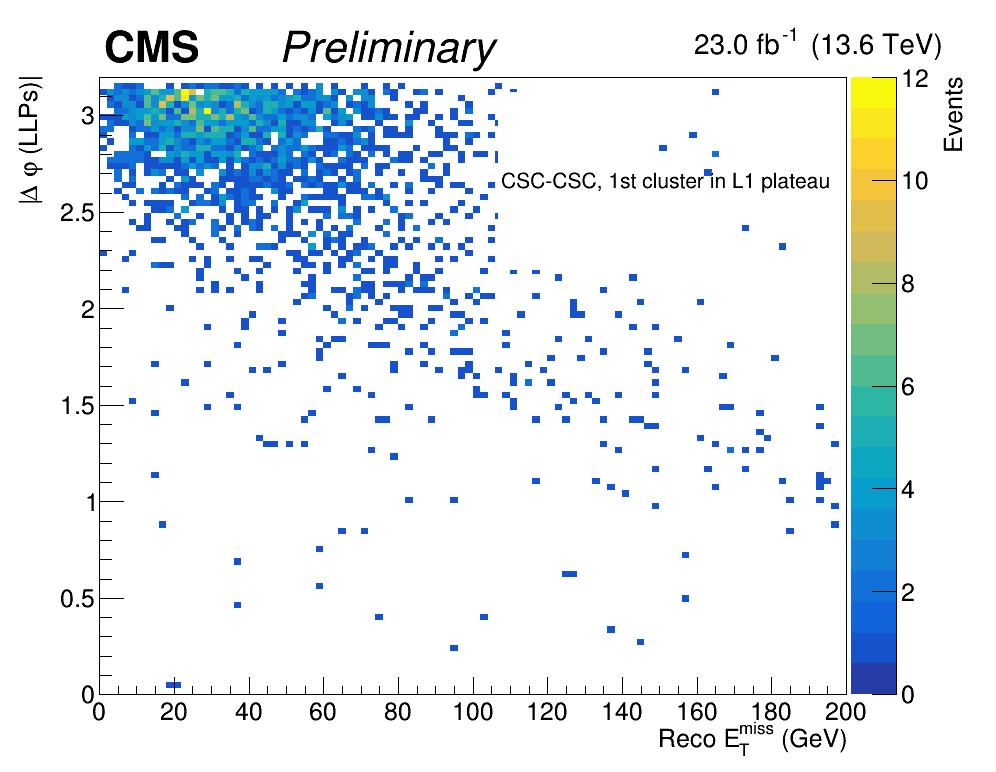

In [22]:
if category == 2 or category==1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    for k in tree_keys:
        tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
    
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))
        reco_met = tmp_met[dim_cut]
        h2[k] = create_TH2D(np.vstack((reco_met, gLLP_dPhi)).T,title="",axis_title = ['Reco E_{T}^{miss} (GeV)','|#Delta #varphi (LLPs)|','Events'], binning=[100,0,200,100,0,3.2])
        leg.SetHeader('CSC-CSC, 1st cluster in L1 plateau' if category==1 else 'DT-CSC, CSC cluster in L1 plateau')
        #h2[k].SetMaximum(100)
        if 'signal' in k:
            h2[k].Draw("colz")
            print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)

        
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    #can.SetLogz()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaPhi_vs_MET_in_plateau"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/GenDeltaPhi_vs_MET_in_plateau"+plot_string+".png")
    #can.Close()

### Reco delta phi vs MET

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

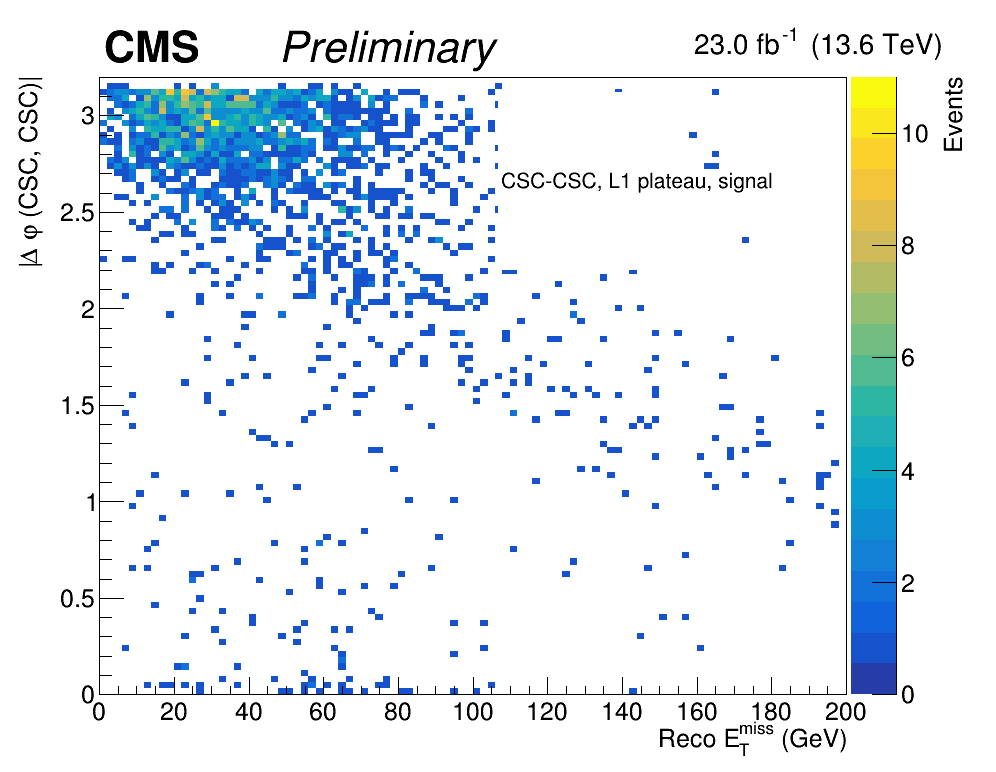

In [23]:
if category == 2 or category==1:
    for k in tree_keys:
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.65,0.65,0.88)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()        
        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)!=0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)>50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_met = tmp_met[tmp_blind]
        else:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_met, tmp_dPhi)).T,title="",axis_title = ['Reco E_{T}^{miss} (GeV)','|#Delta #varphi (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,200,100,0,3.2])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data OOT' if category==1 else 'DT-CSC, L1 plateau, data OOT')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_vs_MET_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_vs_MET_in_plateau_"+k+plot_string+".png")
        #can.Close()

## Delta Eta

{'datav6': array([ True,  True,  True, ..., False,  True, False]), 'signalv6': array([False,  True, False, ...,  True, False, False])}
datav6


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

signalv6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/DeltaEta_csc_clusters_gen_match_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/DeltaEta_csc_clusters_gen_match_exac

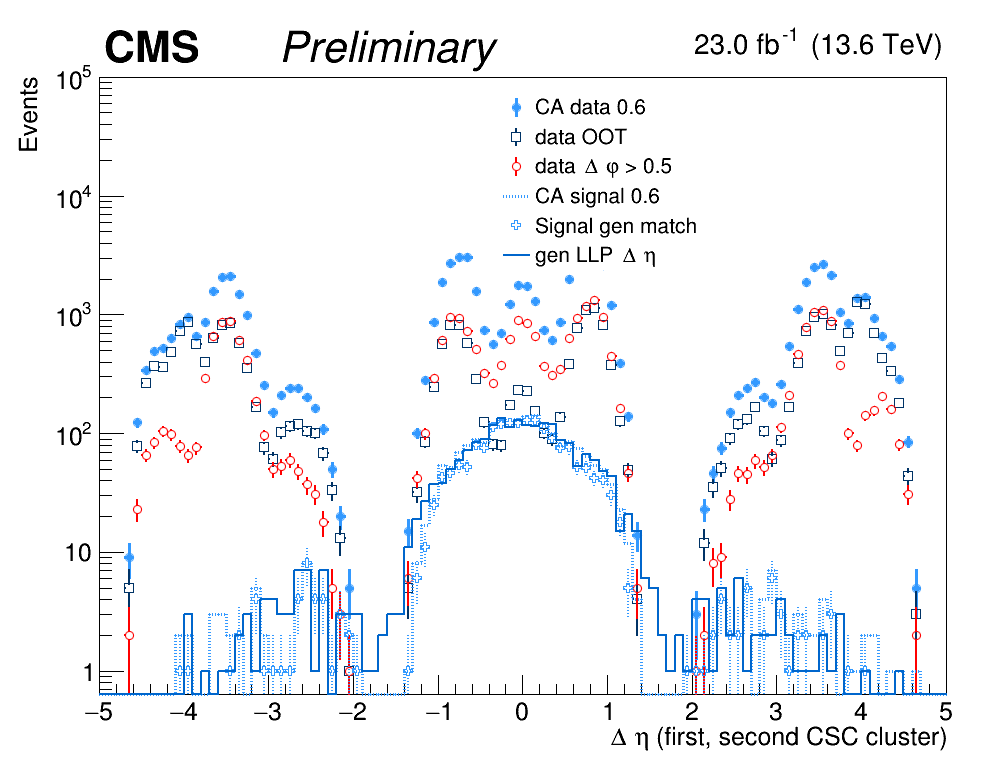

In [24]:
if category == 1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    hoot = {}
    hphi = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    print(first_in_plateau)
    nevents_passing = {}
    for k in tree_keys:
        print(k)
        tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        tmp_cscClusterEta = cscClusterEta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        tmp_cscClusterPhi = cscClusterPhi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]

        gen_match = (cscCluster_match_gLLP_csc[k] [  cscCluster_match_gLLP_minDeltaR[k]<0.4 ].sum() == 2  )

        tmp_eta_gm = cscClusterEta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k]  & gen_match]
        tmp_phi_gm = cscClusterPhi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k] & gen_match ]

        tmp_dEta = (tmp_cscClusterEta[:,0].flatten() - tmp_cscClusterEta[:,1].flatten() )
        tmp_dPhi = deltaPhi(tmp_cscClusterPhi[:,0].flatten() , tmp_cscClusterPhi[:,1].flatten() )
        tmp_dEta_gm = (tmp_eta_gm[:,0].flatten() - tmp_eta_gm[:,1].flatten() )

        tmp_eta_gen = gLLP_eta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dEta = (tmp_eta_gen[dim_cut][:,0].flatten() - tmp_eta_gen[dim_cut][:,1].flatten())
    
        h1[k] = create_TH1D(tmp_dEta,title="",axis_title = ['#Delta #eta (first, second CSC cluster)','Events'], binning=[100,-5,5])
        hsm[k] = create_TH1D(tmp_dEta_gm,title="",axis_title = ['#Delta #eta (first, second CSC cluster)','Events'], binning=[100,-5,5])
        hg[k] = create_TH1D(gLLP_dEta,title="",axis_title = ['#Delta #eta (first, second CSC cluster)','Events'], binning=[100,-5,5])

        
        tmp_oot = (np.abs(cscClusterTime[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ][:,1]) > 50)
        tmp_dEta_oot = (tmp_cscClusterEta[tmp_oot][:,0].flatten() - tmp_cscClusterEta[tmp_oot][:,1].flatten())
        hoot[k] = create_TH1D(tmp_dEta_oot,title="",axis_title = ['|#Delta R (first, second CSC cluster)|','Events'], binning=[100,-5,5])
        hphi[k] = create_TH1D(tmp_dEta[ tmp_dPhi>0.5 ],title="",axis_title = ['|#Delta R (first, second CSC cluster)|','Events'], binning=[100,-5,5])

        
        
        leg.AddEntry(h1[k],data_label[k],'PE' if 'data' in k else 'L')
        h1[k].SetLineColor(colors[k])
        h1[k].SetLineWidth(3)
        h1[k].SetLineStyle(line_style[k])
        h1[k].SetMarkerColor(colors[k])
        h1[k].SetMarkerStyle(marker_style[k])
        h1[k].SetMarkerSize(1.2)
        #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
        h1[k].SetMaximum(1.e05)
        
        if 'data' in k:
            hoot[k].SetLineColor(colors[k]+2)
            hoot[k].SetLineWidth(2)
            hoot[k].SetLineStyle(1)
            hoot[k].SetMarkerColor(colors[k]+2)
            hoot[k].SetMarkerStyle(25)
            hoot[k].SetMarkerSize(1.2)
            hoot[k].Draw('PE same')
            leg.AddEntry(hoot[k],'data OOT','PE')
            hphi[k].SetLineColor(2)
            hphi[k].SetLineWidth(2)
            hphi[k].SetLineStyle(1)
            hphi[k].SetMarkerColor(2)
            hphi[k].SetMarkerStyle(24)
            hphi[k].SetMarkerSize(1.2)
            hphi[k].Draw('PE same')
            leg.AddEntry(hphi[k],'data #Delta #varphi > 0.5','PE')
            
        hsm[k].SetLineColor(colors[k])
        hsm[k].SetLineWidth(2)
        hsm[k].SetLineStyle(line_style[k])
        hsm[k].SetMarkerColor(colors[k])
        hsm[k].SetMarkerStyle(28)
        hsm[k].SetMarkerSize(1.2)

        hg[k].SetLineColor(colors[k]+1)
        hg[k].SetLineWidth(2)
        hg[k].SetLineStyle(1)
        hg[k].SetMarkerColor(colors[k]+1)
        hg[k].SetMarkerStyle(28)
        hg[k].SetMarkerSize(1.2)    
        if 'signal' in k:
            leg.AddEntry(hsm[k],'Signal gen match','P')
            leg.AddEntry(hg[k],'gen LLP #Delta #eta',"L")
            hsm[k].Draw('P same')
            hg[k].Draw('HISTO same')

    
        nevents_passing[k] = event_cut[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k]  ].sum()
    
    leg.Draw()
    can.SetRightMargin(0.05)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/DeltaEta_csc_clusters_gen_match"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/DeltaEta_csc_clusters_gen_match"+plot_string+".png")
    #can.Close()

In [25]:
if category == 2:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    #print(first_in_plateau)
    nevents_passing = {}
    for k in tree_keys:
        #print(k)
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)

        #This must be fixed to dt-csc...
        gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
    

        tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        tmp_dEta = (tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
        tmp_dEta_gm = (tmp_csc_eta_gm.flatten() - tmp_dt_eta_gm.flatten())

        tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        gLLP_dEta = (tmp_eta_gen[dim_cut][:,0].flatten() - tmp_eta_gen[dim_cut][:,1].flatten())
    
        h1[k] = create_TH1D(tmp_dEta,title="",axis_title = ['#Delta #eta (CSC, DT cluster)','Events'], binning=[100,-5,5])
        hsm[k] = create_TH1D(tmp_dEta_gm,title="",axis_title = ['#Delta #eta (CSC, DT cluster)','Events'], binning=[100,-5,5])
        hg[k] = create_TH1D(gLLP_dEta,title="",axis_title = ['#Delta #eta (CSC, DT cluster)','Events'], binning=[100,-5,5])
    
        leg.AddEntry(h1[k],data_label[k],'PE' if 'data' in k else 'L')
        h1[k].SetLineColor(colors[k])
        h1[k].SetLineWidth(3)
        h1[k].SetLineStyle(line_style[k])
        h1[k].SetMarkerColor(colors[k])
        h1[k].SetMarkerStyle(marker_style[k])
        h1[k].SetMarkerSize(1.2)
        #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
        h1[k].SetMaximum(1.e05)
    
        hsm[k].SetLineColor(colors[k])
        hsm[k].SetLineWidth(2)
        hsm[k].SetLineStyle(line_style[k])
        hsm[k].SetMarkerColor(colors[k])
        hsm[k].SetMarkerStyle(28)
        hsm[k].SetMarkerSize(1.2)

        hg[k].SetLineColor(colors[k]+1)
        hg[k].SetLineWidth(2)
        hg[k].SetLineStyle(1)
        hg[k].SetMarkerColor(colors[k]+1)
        hg[k].SetMarkerStyle(28)
        hg[k].SetMarkerSize(1.2)    
        if 'signal' in k:
            leg.AddEntry(hsm[k],'Signal gen match','P')
            leg.AddEntry(hg[k],'gen LLP #Delta #eta',"L")
            hsm[k].Draw('P same')
            hg[k].Draw('HISTO same')

        
        nevents_passing[k] = event_cut[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k]  ].sum()
    
    leg.Draw()
    can.SetRightMargin(0.05)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/DeltaEta_csc_dt_clusters_gen_match"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/DeltaEta_csc_dt_clusters_gen_match"+plot_string+".png")
    #can.Close()

## Delta phi vs delta eta

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

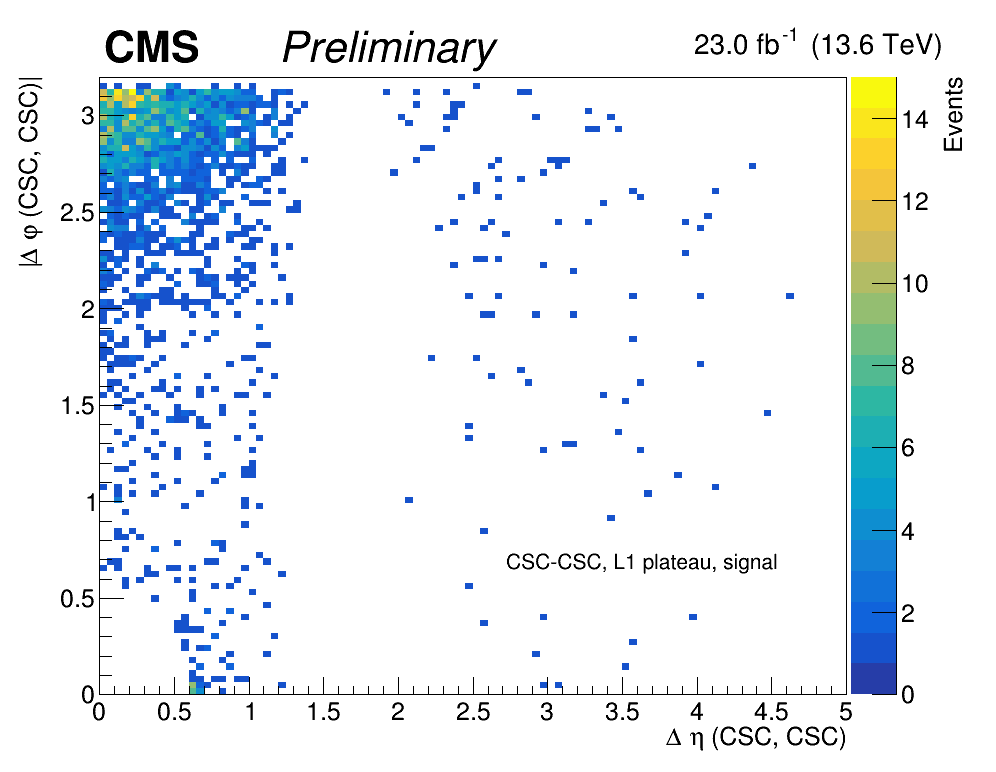

In [26]:
if category == 2 or category==1:
    for k in tree_keys:
        #if 'signal' in k:
        #    continue
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.25,0.85,0.3)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()
        

        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)!=0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)>50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta[tmp_blind].flatten() - tmp_dtClusterEta[tmp_blind].flatten())
            tmp_met = tmp_met[tmp_blind]
        else:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_dEta, tmp_dPhi)).T,title="",axis_title = ['#Delta #eta (CSC, '+('DT' if category==2 else 'CSC')+')','|#Delta #varphi (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,5,100,0,3.2])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data OOT' if category==1 else 'DT-CSC, L1 plateau, data OOT')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_vs_DeltaEta_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_vs_DeltaEta_in_plateau_"+k+plot_string+".png")
        #can.Close()

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/DeltaPhi_vs_DeltaEta_in_time_in_plateau_datav6_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/DeltaPhi_vs_DeltaEta_in_time_plateau_datav6_exactly_2_csc_clusters_ME_veto.png has be

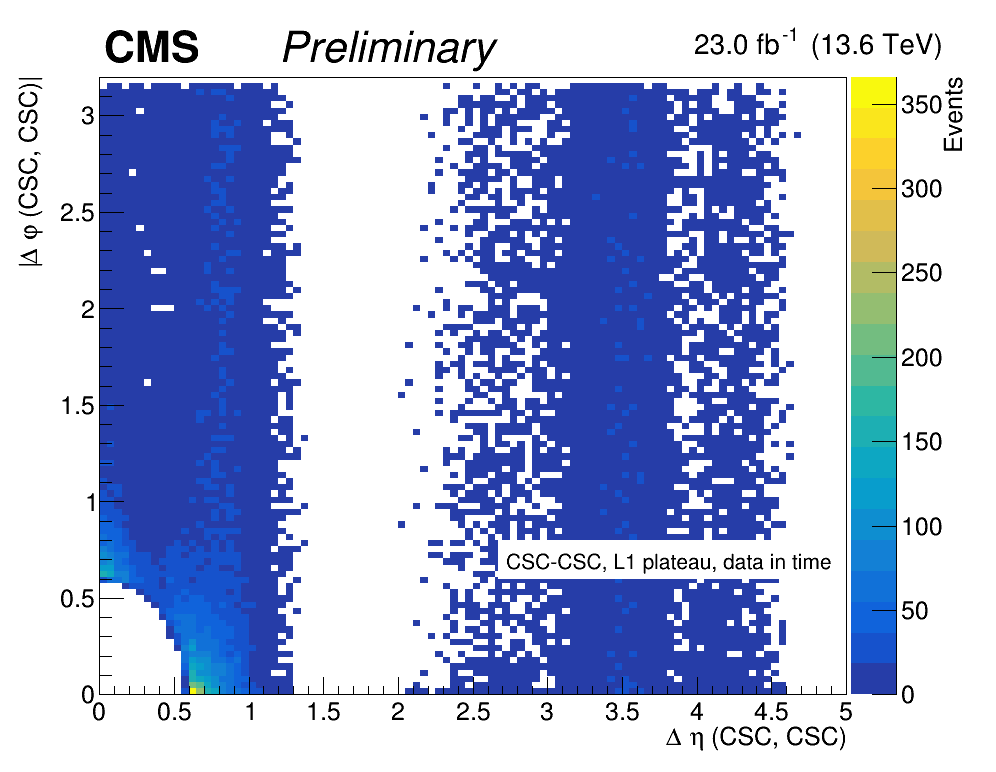

In [27]:
if category == 2 or category==1:
    for k in tree_keys:
        if 'signal' in k:
            continue
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.25,0.85,0.3)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()
        

        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)==0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)<50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta[tmp_blind].flatten() - tmp_dtClusterEta[tmp_blind].flatten())
            tmp_met = tmp_met[tmp_blind]
        else:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_dEta, tmp_dPhi)).T,title="",axis_title = ['#Delta #eta (CSC, '+('DT' if category==2 else 'CSC')+')','|#Delta #varphi (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,5,100,0,3.2])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data in time' if category==1 else 'DT-CSC, L1 plateau, data in time')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_vs_DeltaEta_in_time_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_vs_DeltaEta_in_time_plateau_"+k+plot_string+".png")
        #can.Close()

## Delta phi vs delta R

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

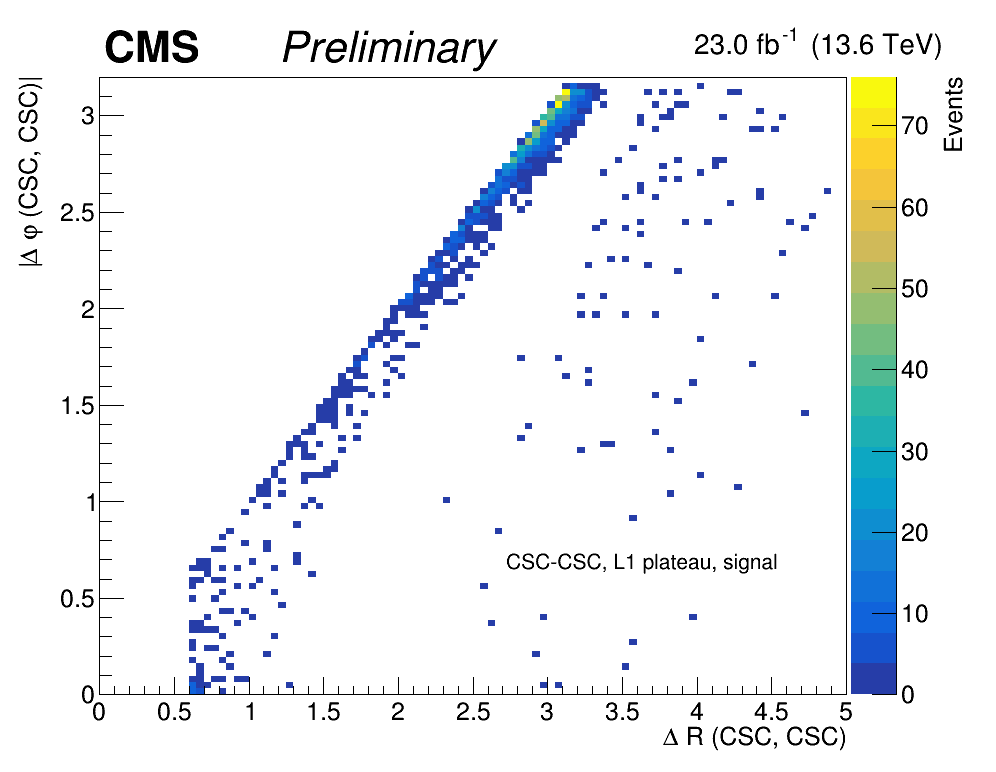

In [28]:
if category == 2 or category==1:
    for k in tree_keys:
        #if 'signal' in k:
        #    continue
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.25,0.85,0.3)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()
        

        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)!=0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)>50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dR = np.abs(deltaR(tmp_cscClusterEta[tmp_blind].flatten(), tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterEta[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta[tmp_blind].flatten() - tmp_dtClusterEta[tmp_blind].flatten())
            tmp_met = tmp_met[tmp_blind]
        else:
            tmp_dR = np.abs(deltaR(tmp_cscClusterEta.flatten(), tmp_cscClusterPhi.flatten(), tmp_dtClusterEta.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_dR, tmp_dPhi)).T,title="",axis_title = ['#Delta R (CSC, '+('DT' if category==2 else 'CSC')+')','|#Delta #varphi (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,5,100,0,3.2])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data OOT' if category==1 else 'DT-CSC, L1 plateau, data OOT')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_vs_DeltaR_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_vs_DeltaR_in_plateau_"+k+plot_string+".png")
        #can.Close()

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/DeltaPhi_vs_DeltaR_in_time_in_plateau_datav6_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/DeltaPhi_vs_DeltaR_in_time_plateau_datav6_exactly_2_csc_clusters_ME_veto.png has been c

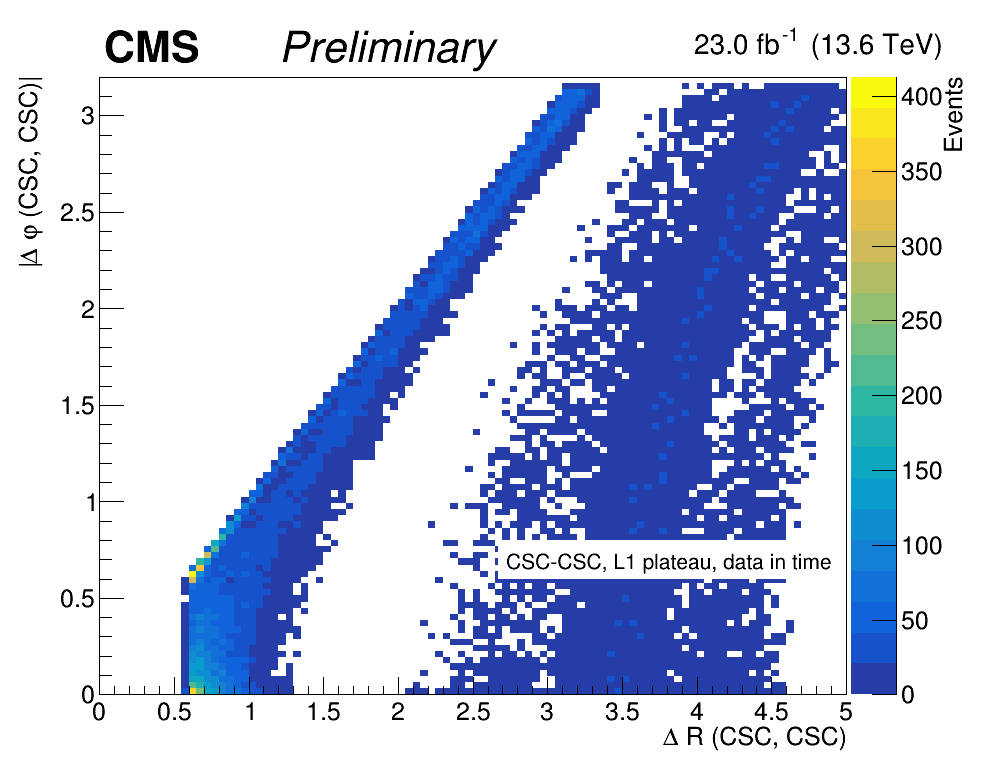

In [29]:
if category == 2 or category==1:
    for k in tree_keys:
        if 'signal' in k:
            continue
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.25,0.85,0.3)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()
        

        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)==0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)<50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dR = np.abs(deltaR(tmp_cscClusterEta[tmp_blind].flatten(), tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterEta[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta[tmp_blind].flatten() - tmp_dtClusterEta[tmp_blind].flatten())
            tmp_met = tmp_met[tmp_blind]
        else:
            tmp_dR = np.abs(deltaR(tmp_cscClusterEta.flatten(), tmp_cscClusterPhi.flatten(), tmp_dtClusterEta.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_dR, tmp_dPhi)).T,title="",axis_title = ['#Delta R (CSC, '+('DT' if category==2 else 'CSC')+')','|#Delta #varphi (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,5,100,0,3.2])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data in time' if category==1 else 'DT-CSC, L1 plateau, data in time')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_vs_DeltaR_in_time_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_vs_DeltaR_in_time_plateau_"+k+plot_string+".png")
        #can.Close()

## Delta eta vs delta R

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

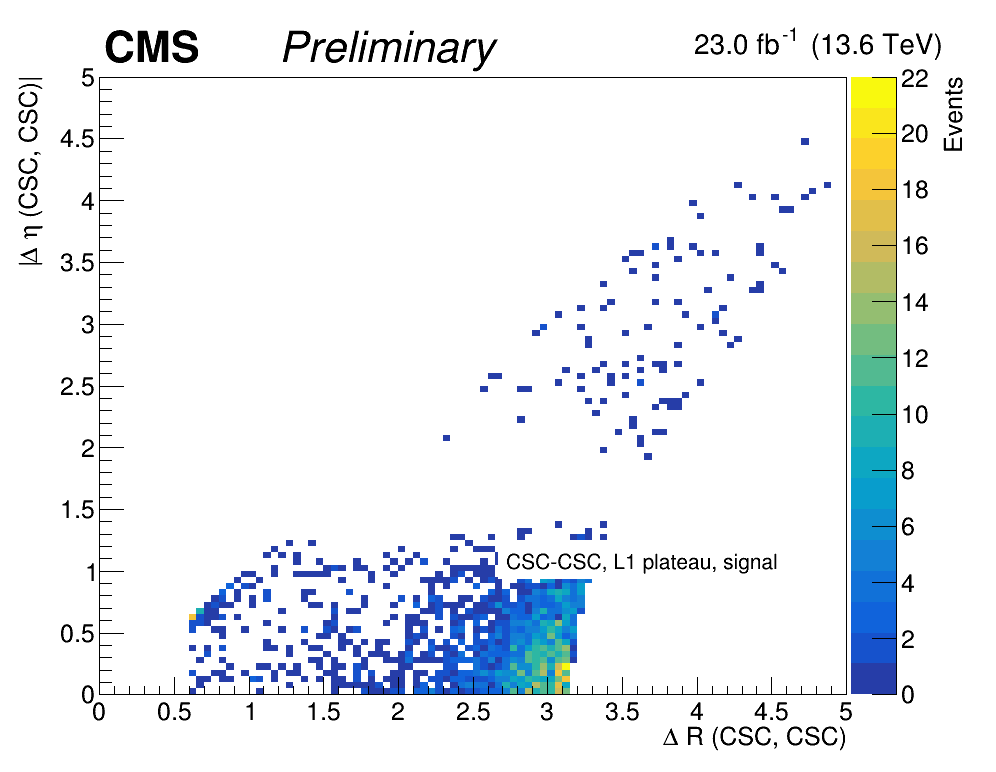

In [30]:
if category == 2 or category==1:
    for k in tree_keys:
        #if 'signal' in k:
        #    continue
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.25,0.85,0.3)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()
        

        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)!=0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)>50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dR = np.abs(deltaR(tmp_cscClusterEta[tmp_blind].flatten(), tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterEta[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta[tmp_blind].flatten() - tmp_dtClusterEta[tmp_blind].flatten())
            tmp_met = tmp_met[tmp_blind]
        else:
            tmp_dR = np.abs(deltaR(tmp_cscClusterEta.flatten(), tmp_cscClusterPhi.flatten(), tmp_dtClusterEta.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_dR, tmp_dEta)).T,title="",axis_title = ['#Delta R (CSC, '+('DT' if category==2 else 'CSC')+')','|#Delta #eta (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,5,100,0,5])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data OOT' if category==1 else 'DT-CSC, L1 plateau, data OOT')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaEta_vs_DeltaR_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaEta_vs_DeltaR_in_plateau_"+k+plot_string+".png")
        #can.Close()

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/DeltaEta_vs_DeltaR_in_time_in_plateau_datav6_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/DeltaEta_vs_DeltaR_in_time_plateau_datav6_exactly_2_csc_clusters_ME_veto.png has been c

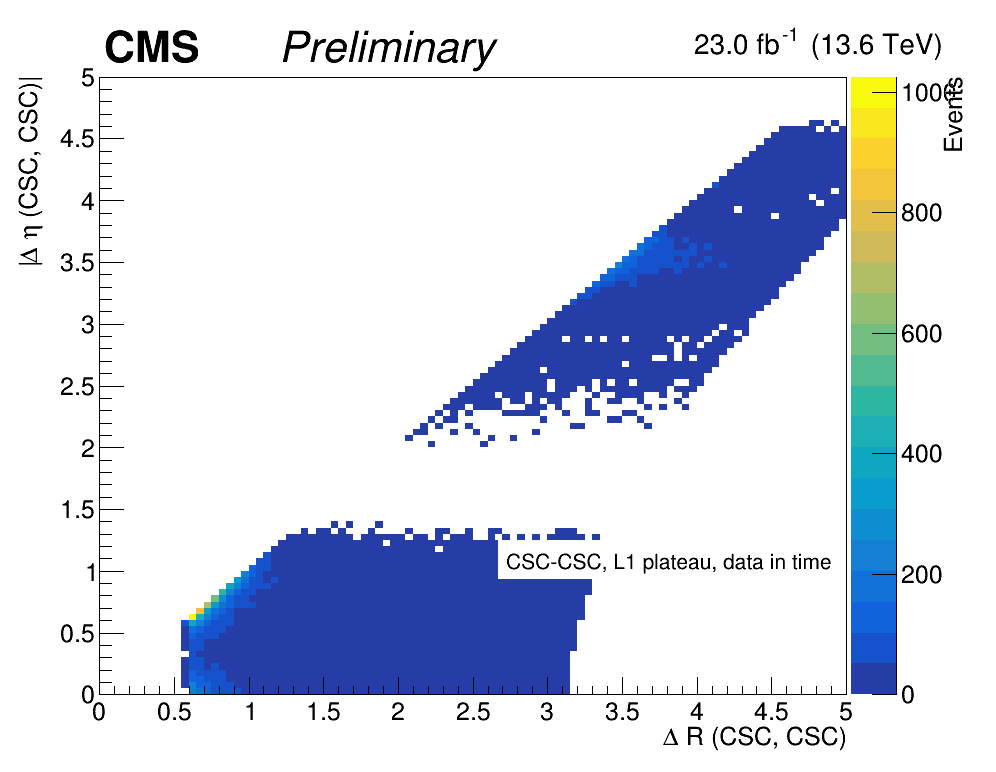

In [31]:
if category == 2 or category==1:
    for k in tree_keys:
        if 'signal' in k:
            continue
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.25,0.85,0.3)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()
        

        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)==0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)<50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dR = np.abs(deltaR(tmp_cscClusterEta[tmp_blind].flatten(), tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterEta[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta[tmp_blind].flatten() - tmp_dtClusterEta[tmp_blind].flatten())
            tmp_met = tmp_met[tmp_blind]
        else:
            tmp_dR = np.abs(deltaR(tmp_cscClusterEta.flatten(), tmp_cscClusterPhi.flatten(), tmp_dtClusterEta.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_dR, tmp_dEta)).T,title="",axis_title = ['#Delta R (CSC, '+('DT' if category==2 else 'CSC')+')','|#Delta #eta (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,5,100,0,5])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data in time' if category==1 else 'DT-CSC, L1 plateau, data in time')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaEta_vs_DeltaR_in_time_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaEta_vs_DeltaR_in_time_plateau_"+k+plot_string+".png")
        #can.Close()

## Delta Time

{'datav6': array([ True,  True,  True, ..., False,  True, False]), 'signalv6': array([False,  True, False, ...,  True, False, False])}
datav6


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

signalv6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/DeltaTime_csc_clusters_gen_match_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/DeltaTime_csc_clusters_gen_match_exactly_2_csc_clusters_ME_veto.png has been created


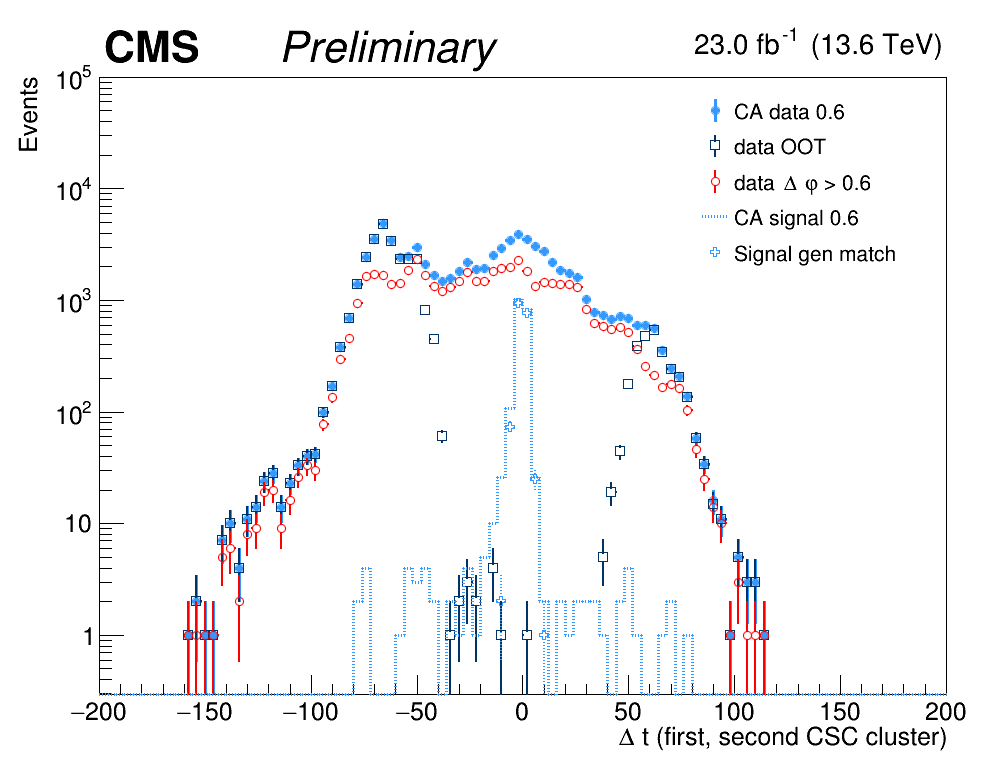

In [35]:
if category == 1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5+0.2,0.65,0.65+0.2,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    hoot = {}
    hphi = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    print(first_in_plateau)
    nevents_passing = {}
    for k in tree_keys:
        print(k)
        tmp_cscClusterTime = cscClusterTime[k][event_cut[k] & first_in_plateau[k] ]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ]
        
        gen_match = (cscCluster_match_gLLP_csc[k] [  cscCluster_match_gLLP_minDeltaR[k]<0.4 ].sum() == 2  )

        tmp_t_gm = cscClusterTime[k][ event_cut[k] & first_in_plateau[k]  & gen_match]

        tmp_dt = (tmp_cscClusterTime[:,0].flatten() - tmp_cscClusterTime[:,1].flatten() )
        tmp_dt_gm = (tmp_t_gm[:,0].flatten() - tmp_t_gm[:,1].flatten() )
        tmp_dPhi = np.abs(deltaPhi( tmp_cscClusterPhi[:,0].flatten(), tmp_cscClusterPhi[:,1].flatten()))

        h1[k] = create_TH1D(tmp_dt,title="",axis_title = ['#Delta t (first, second CSC cluster)','Events'], binning=[100,-200,200])
        hsm[k] = create_TH1D(tmp_dt_gm,title="",axis_title = ['#Delta t (first, second CSC cluster)','Events'], binning=[100,-200,200])
        
        tmp_oot = (np.abs(cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]) > 50)
        tmp_dt_oot = (tmp_cscClusterTime[tmp_oot][:,0].flatten() - tmp_cscClusterTime[tmp_oot][:,1].flatten())
        hoot[k] = create_TH1D(tmp_dt_oot,title="",axis_title = ['|#Delta t (first, second CSC cluster)|','Events'], binning=[100,-200,200])
        hphi[k] = create_TH1D(tmp_dt[ tmp_dPhi>0.6 ],title="",axis_title = ['|#Delta t (first, second CSC cluster)|','Events'], binning=[100,-200,200])

        
        
        leg.AddEntry(h1[k],data_label[k],'PE' if 'data' in k else 'L')
        h1[k].SetLineColor(colors[k])
        h1[k].SetLineWidth(3)
        h1[k].SetLineStyle(line_style[k])
        h1[k].SetMarkerColor(colors[k])
        h1[k].SetMarkerStyle(marker_style[k])
        h1[k].SetMarkerSize(1.2)
        #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
        h1[k].SetMaximum(1.e05)
        
        if 'data' in k:
            hoot[k].SetLineColor(colors[k]+2)
            hoot[k].SetLineWidth(2)
            hoot[k].SetLineStyle(1)
            hoot[k].SetMarkerColor(colors[k]+2)
            hoot[k].SetMarkerStyle(25)
            hoot[k].SetMarkerSize(1.2)
            hoot[k].Draw('PE same')
            leg.AddEntry(hoot[k],'data OOT','PE')
            hphi[k].SetLineColor(2)
            hphi[k].SetLineWidth(2)
            hphi[k].SetLineStyle(1)
            hphi[k].SetMarkerColor(2)
            hphi[k].SetMarkerStyle(24)
            hphi[k].SetMarkerSize(1.2)
            hphi[k].Draw('PE same')
            leg.AddEntry(hphi[k],'data #Delta #varphi > 0.6','PE')
            
        hsm[k].SetLineColor(colors[k])
        hsm[k].SetLineWidth(2)
        hsm[k].SetLineStyle(line_style[k])
        hsm[k].SetMarkerColor(colors[k])
        hsm[k].SetMarkerStyle(28)
        hsm[k].SetMarkerSize(1.2)

        #hg[k].SetLineColor(colors[k]+1)
        #hg[k].SetLineWidth(2)
        #hg[k].SetLineStyle(1)
        #hg[k].SetMarkerColor(colors[k]+1)
        #hg[k].SetMarkerStyle(28)
        #hg[k].SetMarkerSize(1.2)    
        if 'signal' in k:
            leg.AddEntry(hsm[k],'Signal gen match','P')
            #leg.AddEntry(hg[k],'gen LLP #Delta #eta',"L")
            hsm[k].Draw('P same')
            #hg[k].Draw('HISTO same')

    
        nevents_passing[k] = event_cut[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k]  ].sum()
    
    leg.Draw()
    can.SetRightMargin(0.05)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+plot_folder+"/DeltaTime_csc_clusters_gen_match"+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/DeltaTime_csc_clusters_gen_match"+plot_string+".png")
    #can.Close()

## Delta time vs delta eta

# TODO

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

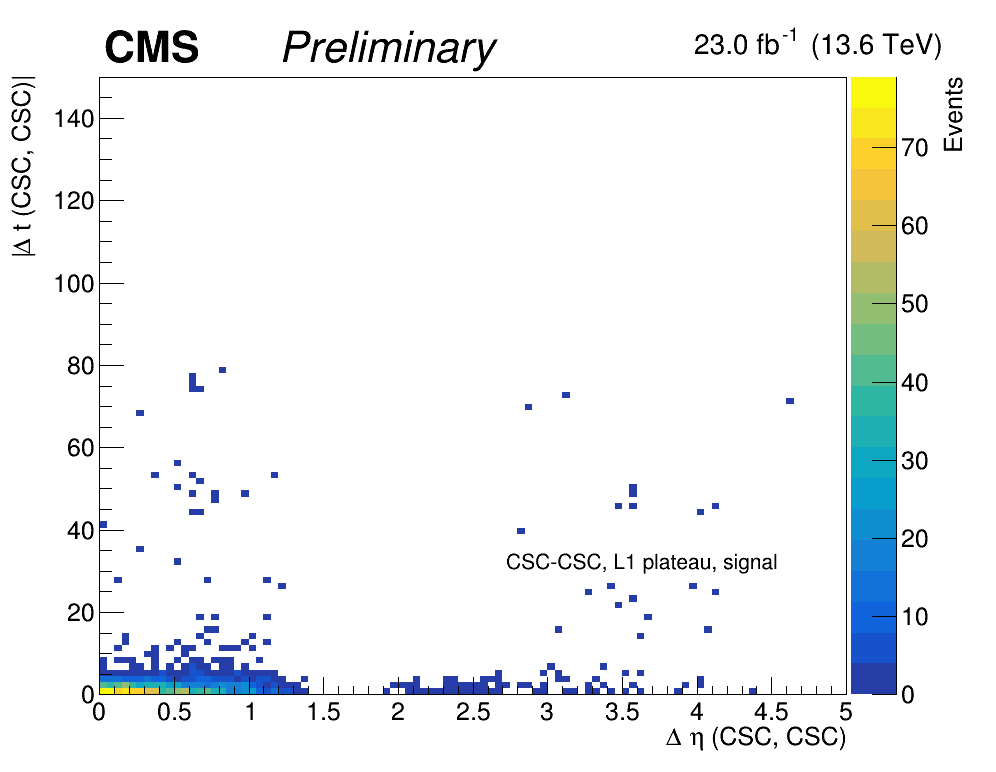

In [37]:
if category == 2 or category==1:
    for k in tree_keys:
        #if 'signal' in k:
        #    continue
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.25,0.85,0.3)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()
        
        #if 'signal' in k: continue
        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)!=0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)>50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta[tmp_blind].flatten() - tmp_dtClusterEta[tmp_blind].flatten())
            tmp_met = tmp_met[tmp_blind]
            tmp_dt  = np.abs( tmp_cscClusterTime[tmp_blind].flatten() - tmp_dtClusterTime[tmp_blind].flatten() )
        else:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
            tmp_dt  = np.abs( tmp_cscClusterTime.flatten() - tmp_dtClusterTime.flatten() )
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_dEta, tmp_dt)).T,title="",axis_title = ['#Delta #eta (CSC, '+('DT' if category==2 else 'CSC')+')','|#Delta t (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,5,100,0,150])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data OOT' if category==1 else 'DT-CSC, L1 plateau, data OOT')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaTime_vs_DeltaEta_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaTime_vs_DeltaEta_in_plateau_"+k+plot_string+".png")
        #can.Close()

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/DeltaTime_vs_DeltaEta_in_time_in_plateau_datav6_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/DeltaTime_vs_DeltaEta_in_time_plateau_datav6_exactly_2_csc_clusters_ME_veto.png has 

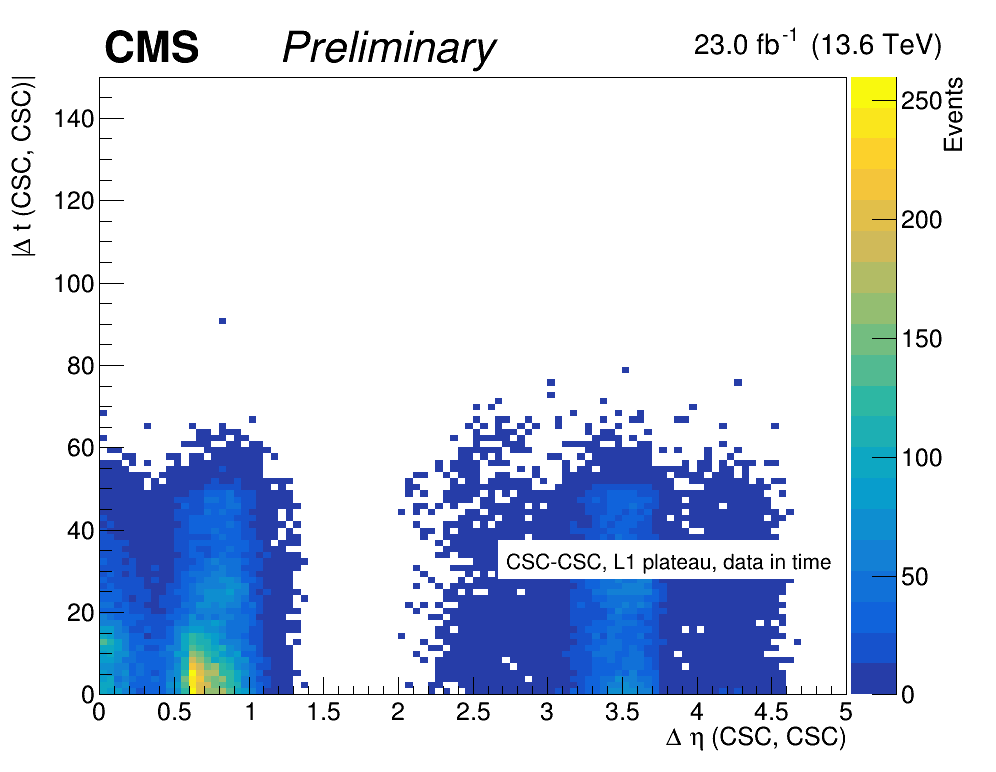

In [38]:
if category == 2 or category==1:
    for k in tree_keys:
        if 'signal' in k:
            continue
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.25,0.85,0.3)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()
        

        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)==0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)<50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta[tmp_blind].flatten() - tmp_dtClusterEta[tmp_blind].flatten())
            tmp_met = tmp_met[tmp_blind]
            tmp_dt  = np.abs( tmp_cscClusterTime[tmp_blind].flatten() - tmp_dtClusterTime[tmp_blind].flatten() )
        else:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_dEta, tmp_dt)).T,title="",axis_title = ['#Delta #eta (CSC, '+('DT' if category==2 else 'CSC')+')','|#Delta t (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,5,100,0,150])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data in time' if category==1 else 'DT-CSC, L1 plateau, data in time')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaTime_vs_DeltaEta_in_time_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaTime_vs_DeltaEta_in_time_plateau_"+k+plot_string+".png")
        #can.Close()

## Delta time vs delta phi

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

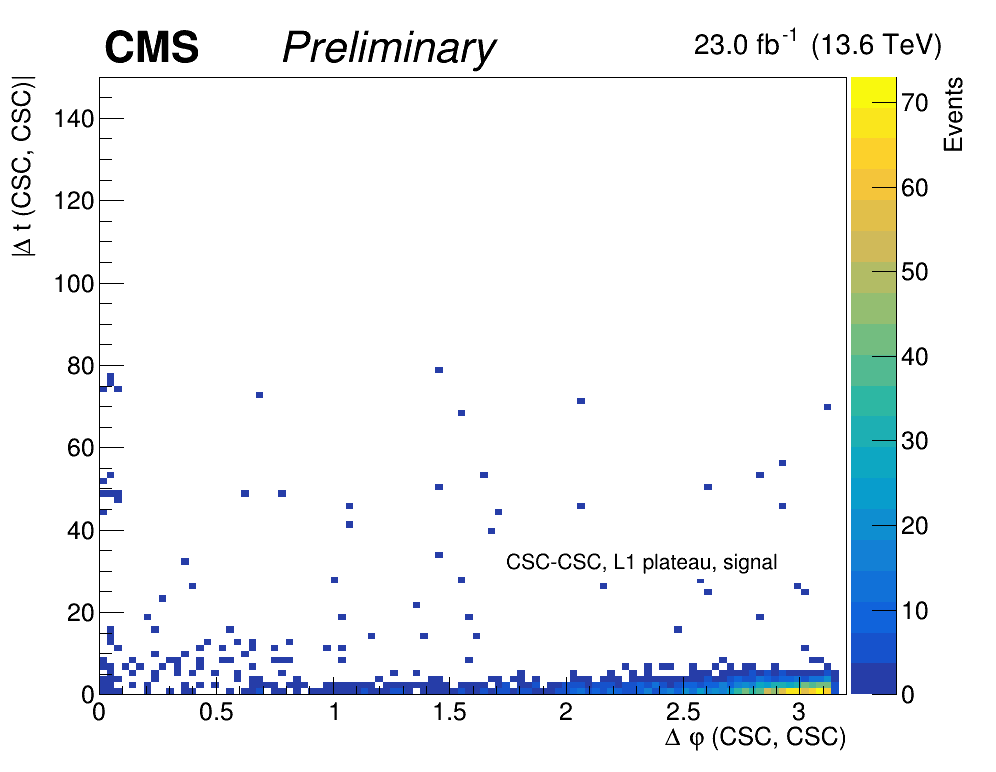

In [39]:
if category == 2 or category==1:
    for k in tree_keys:
        #if 'signal' in k:
        #    continue
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.25,0.85,0.3)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()
        
        #if 'signal' in k: continue
        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)!=0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)>50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta[tmp_blind].flatten() - tmp_dtClusterEta[tmp_blind].flatten())
            tmp_met = tmp_met[tmp_blind]
            tmp_dt  = np.abs( tmp_cscClusterTime[tmp_blind].flatten() - tmp_dtClusterTime[tmp_blind].flatten() )
        else:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
            tmp_dt  = np.abs( tmp_cscClusterTime.flatten() - tmp_dtClusterTime.flatten() )
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_dPhi, tmp_dt)).T,title="",axis_title = ['#Delta #varphi (CSC, '+('DT' if category==2 else 'CSC')+')','|#Delta t (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,3.2,100,0,150])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data OOT' if category==1 else 'DT-CSC, L1 plateau, data OOT')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaTime_vs_DeltaPhi_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaTime_vs_DeltaPhi_in_plateau_"+k+plot_string+".png")
        #can.Close()

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/DeltaTime_vs_DeltaPhi_in_time_in_plateau_datav6_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/DeltaTime_vs_DeltaPhi_in_time_plateau_datav6_exactly_2_csc_clusters_ME_veto.png has 

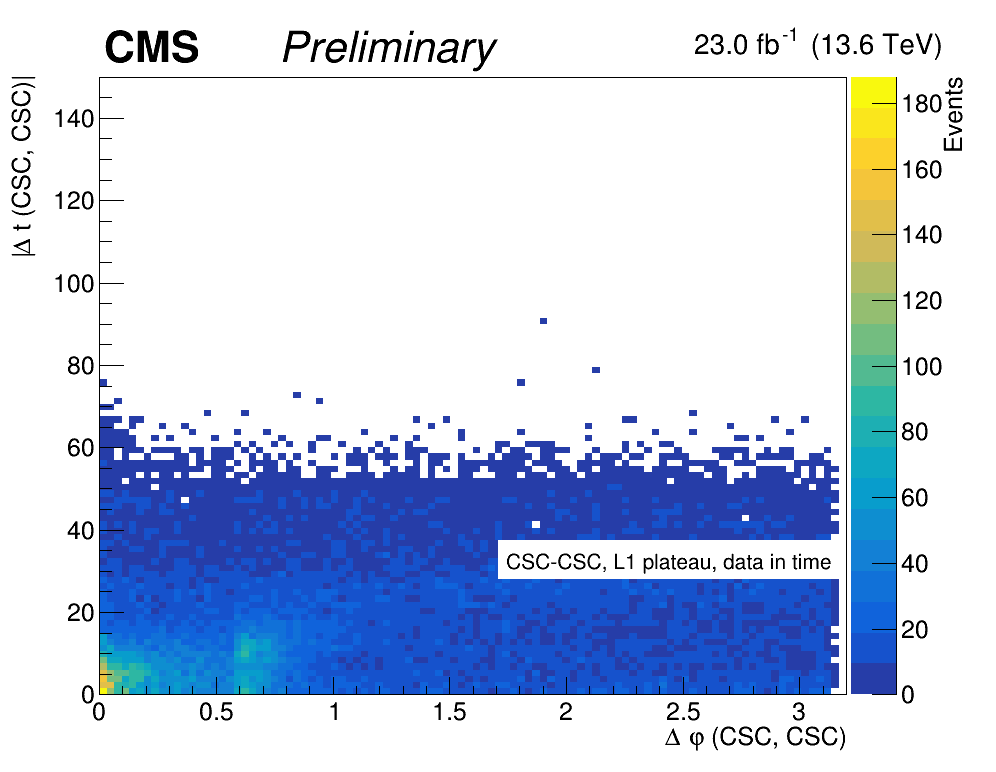

In [40]:
if category == 2 or category==1:
    for k in tree_keys:
        if 'signal' in k:
            continue
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.25,0.85,0.3)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        hsm = {}
        hg = {}
        h2 = {}
        can.cd()
        

        
        tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
        tmp_cscClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
        
        if category==2:
            tmp_dtClusterSize = dtClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterEta = dtClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterPhi = dtClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,0]
            tmp_dtClusterGenMatch = (dtCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,0] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)==0
        else:
            tmp_dtClusterSize = cscClusterSize[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterEta = cscClusterEta[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterPhi = cscClusterPhi[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterTime = cscClusterTime[k][ event_cut[k] & first_in_plateau[k] ][:,1]
            tmp_dtClusterGenMatch = (cscCluster_match_gLLP_minDeltaR[k][ event_cut[k] & first_in_plateau[k] ][:,1] < 0.4)
            tmp_blind = np.abs(tmp_dtClusterTime)<50
            
        tmp_met = met[k][ event_cut[k] & first_in_plateau[k] ]
        if 'data' in k:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi[tmp_blind].flatten(), tmp_dtClusterPhi[tmp_blind].flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta[tmp_blind].flatten() - tmp_dtClusterEta[tmp_blind].flatten())
            tmp_met = tmp_met[tmp_blind]
            tmp_dt  = np.abs( tmp_cscClusterTime[tmp_blind].flatten() - tmp_dtClusterTime[tmp_blind].flatten() )
        else:
            tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_dtClusterPhi.flatten()))
            tmp_dEta = np.abs(tmp_cscClusterEta.flatten() -  tmp_dtClusterEta.flatten())
        #gen_match = (tmp_cscClusterGenMatch & tmp_dtClusterGenMatch)
   
        #tmp_csc_eta_gm = tmp_cscClusterEta[gen_match]
        #tmp_csc_phi_gm = tmp_cscClusterPhi[gen_match]
        #tmp_dt_eta_gm = tmp_dtClusterEta[gen_match]
        #tmp_dt_phi_gm = tmp_dtClusterPhi[gen_match]

        
        #tmp_dPhi_gm = np.abs(deltaPhi(tmp_csc_phi_gm.flatten(),tmp_dt_phi_gm.flatten()))

        #tmp_eta_gen = gLLP_eta[k][ event_cut[k] & first_in_plateau[k] ]
        #tmp_phi_gen = gLLP_phi[k][ event_cut[k] & first_in_plateau[k] ]
        #dim_cut = (tmp_eta_gen.astype(bool).sum()==2)
        #gLLP_dPhi = np.abs(deltaPhi(tmp_phi_gen[dim_cut][:,0].flatten(),tmp_phi_gen[dim_cut][:,1].flatten()))

        
        h2[k] = create_TH2D(np.vstack((tmp_dPhi, tmp_dt)).T,title="",axis_title = ['#Delta #varphi (CSC, '+('DT' if category==2 else 'CSC')+')','|#Delta t (CSC, '+('DT' if category==2 else 'CSC')+')|','Events'], binning=[100,0,3.2,100,0,150])
        if 'data' in k:
            leg.SetHeader('CSC-CSC, L1 plateau, data in time' if category==1 else 'DT-CSC, L1 plateau, data in time')
        else:
            leg.SetHeader('CSC-CSC, L1 plateau, signal' if category==1 else 'DT-CSC, L1 plateau, signal')
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Draw("colz")
        #    print(event_cut[k][ (event_cut[k] & first_in_plateau[k]) == True].shape)


        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        #can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+plot_folder+"/DeltaTime_vs_DeltaPhi_in_time_in_plateau_"+k+plot_string+".pdf")
        can.Print("plots/V1p19_"+plot_folder+"/DeltaTime_vs_DeltaPhi_in_time_plateau_"+k+plot_string+".png")
        #can.Close()